In [1]:
from itertools import combinations
import numpy as np
import pyreadr
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import textwrap

import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN, AgglomerativeClustering

from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from scipy.cluster import hierarchy
from scipy.stats import chi2_contingency

from utils import pca, kernel_pca

In [2]:
path = "./gss_16.rda"

In [3]:
data = pyreadr.read_r(path)

In [4]:
df = data["gss16"]

In [5]:
df

,harass5,emailmin,emailhr,educ,polviews,advfront,snapchat,instagrm,wrkstat
0,NaN,0.0,12.0,16.0,Moderate,Strongly agree,NaN,NaN,Working fulltime
1,NaN,30.0,0.0,12.0,Liberal,Disagree,No,No,Working fulltime
2,No,NaN,NaN,16.0,Conservative,NaN,No,No,Retired
3,NaN,10.0,0.0,12.0,Moderate,Disagree,NaN,NaN,Working parttime
4,No,NaN,NaN,18.0,Slightly liberal,NaN,Yes,Yes,Working parttime
...,...,...,...,...,...,...,...,...,...
2862,NaN,0.0,20.0,20.0,Extremely liberal,Agree,No,Yes,Working fulltime
2863,NaN,0.0,2.0,15.0,Conservative,Disagree,NaN,NaN,Working fulltime
2864,No,0.0,0.0,14.0,Moderate,NaN,NaN,NaN,Keeping house
2865,NaN,0.0,1.0,14.0,Slghtly conservative,Agree,NaN,NaN,Working fulltime


In [6]:
df.shape

(2867, 9)

In [7]:
for col in df.columns.tolist():
    print(col, df[col].isna().sum(), len(df[col]), df[col].isna().sum()/len(df[col]))

harass5 1398 2867 0.48761771886989885
emailmin 1218 2867 0.4248343215905127
emailhr 1218 2867 0.4248343215905127
educ 9 2867 0.003139169863969306
polviews 111 2867 0.0387164283222881
advfront 1482 2867 0.5169166376002791
snapchat 1495 2867 0.5214509940704569
instagrm 1495 2867 0.5214509940704569
wrkstat 3 2867 0.0010463899546564353


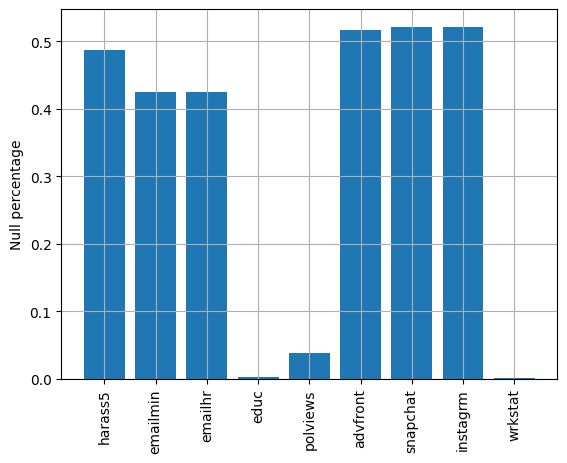

In [8]:
col_to_null_percentage = dict(zip(df.columns.tolist(), map(lambda x: df[x].isna().sum()/len(df[x]), df.columns.tolist())))

plt.bar(col_to_null_percentage.keys(), col_to_null_percentage.values())
plt.xticks(rotation=90)
plt.ylabel("Null percentage")
plt.grid()

In [9]:
columns_to_check = ['educ', 'wrkstat']
df.dropna(subset=columns_to_check, inplace=True)

In [10]:
df['emailtotal'] = np.where(df['emailhr'].isna() | df['emailmin'].isna(), np.nan, df['emailhr'] * 60 + df['emailmin'])
df = df.drop(['emailhr', 'emailmin'], axis=1)

In [11]:
df.shape

(2858, 8)

In [12]:
df = df[df['emailtotal'].isna()]

In [13]:
df = df.drop(['emailtotal'], axis=1)

In [14]:
df.shape

(1210, 7)

In [15]:
column_unique_value = {}
for col in df.columns.tolist():
    if col == 'emailtotal':
        continue
    try:
        print(col, np.unique(df[col].to_numpy()))
        column_unique_value[col] = np.unique(df[col].to_numpy())
    except:
        print(col, list(set(df[col].tolist())))
        column_unique_value[col] = list(set(df[col].tolist()))

harass5 ['No', nan, 'Does not apply (i do not have a job/superior/co-worker)', 'Yes']
educ [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
polviews [nan, 'Conservative', 'Extremely liberal', 'Slightly liberal', 'Slghtly conservative', 'Liberal', 'Moderate', 'Extrmly conservative']
advfront [nan, 'Disagree', 'Strongly agree', 'Agree', 'Dont know', 'Strongly disagree']
snapchat ['No', nan, 'Yes']
instagrm ['No', nan, 'Yes']
wrkstat ['Keeping house' 'Other' 'Retired' 'School' 'Temp not working'
 'Unempl, laid off' 'Working fulltime' 'Working parttime']


In [16]:
value_to_index = {}

for col in df.columns.tolist():
    if col == 'emailtotal':
        continue
    try:
        unique_set = np.unique(df[col].to_numpy()).tolist()
        unique_set = [x for x in unique_set if not math.isnan(x)]
        print(col, unique_set)
        unique_set.sort()
        value_to_index[col] = dict(zip(unique_set, unique_set))
    except:
        #print(col, list(set(df[col].tolist())))
        unique_set = list(set(df[col].tolist()))
        chosens = []
        for i in unique_set:
            if isinstance(i, float):
                if math.isnan(i):
                    continue
            #print(type(i), i)
            chosens.append(i)
        unique_set = chosens
        
        print(col, unique_set)
        unique_set.sort()
    
        if col == "advfront":
            value_to_index[col] = {'Strongly disagree': 1, 'Disagree': 2, 'Dont know': 3, 'Agree': 4, 'Strongly agree': 5}
        elif col == "polviews":
            value_to_index[col] = {'Extrmly conservative': 1, 'Conservative': 2, 'Slghtly conservative': 3, 'Moderate': 4, 'Slightly liberal': 5, 'Liberal': 6, 'Extremely liberal': 7}
        elif col == "educ" or col == "wrkstat":
            value_to_index[col] = dict(zip(unique_set, range(len(unique_set))))
        else:
            value_to_index[col] = dict(zip(unique_set, range(1, len(unique_set) + 1)))
        
print(value_to_index)

harass5 ['No', 'Does not apply (i do not have a job/superior/co-worker)', 'Yes']
educ [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0]
polviews ['Conservative', 'Extremely liberal', 'Slightly liberal', 'Slghtly conservative', 'Liberal', 'Moderate', 'Extrmly conservative']
advfront ['Disagree', 'Strongly agree', 'Agree', 'Dont know', 'Strongly disagree']
snapchat ['No', 'Yes']
instagrm ['No', 'Yes']
wrkstat ['Retired', 'Working fulltime', 'School', 'Keeping house', 'Other', 'Temp not working', 'Working parttime', 'Unempl, laid off']
{'harass5': {'Does not apply (i do not have a job/superior/co-worker)': 1, 'No': 2, 'Yes': 3}, 'educ': {0.0: 0.0, 1.0: 1.0, 2.0: 2.0, 3.0: 3.0, 4.0: 4.0, 5.0: 5.0, 6.0: 6.0, 7.0: 7.0, 8.0: 8.0, 9.0: 9.0, 10.0: 10.0, 11.0: 11.0, 12.0: 12.0, 13.0: 13.0, 14.0: 14.0, 15.0: 15.0, 16.0: 16.0, 17.0: 17.0, 18.0: 18.0, 19.0: 19.0, 20.0: 20.0}, 'polviews': {'Extrmly conservative': 1, 'Conservative': 2

C:\Users\Thanh_Tuyet\AppData\Local\Temp\ipykernel_13636\2404901357.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(wrapped_labels, rotation=90, ha="center")
C:\Users\Thanh_Tuyet\AppData\Local\Temp\ipykernel_13636\2404901357.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(wrapped_labels, rotation=90, ha="center")
C:\Users\Thanh_Tuyet\AppData\Local\Temp\ipykernel_13636\2404901357.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(wrapped_labels, rotation=90, ha="center")
C:\Users\Thanh_Tuyet\AppData\Local\Temp\ipykernel_13636\2404901357.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(wrapped_labels, rotation=90, ha="center")
C:\Users\Thanh_Tuyet\AppData\Local\Temp\ipykernel_13636\2404901357.py:43: UserWarning: FixedFormatter should only be used together w

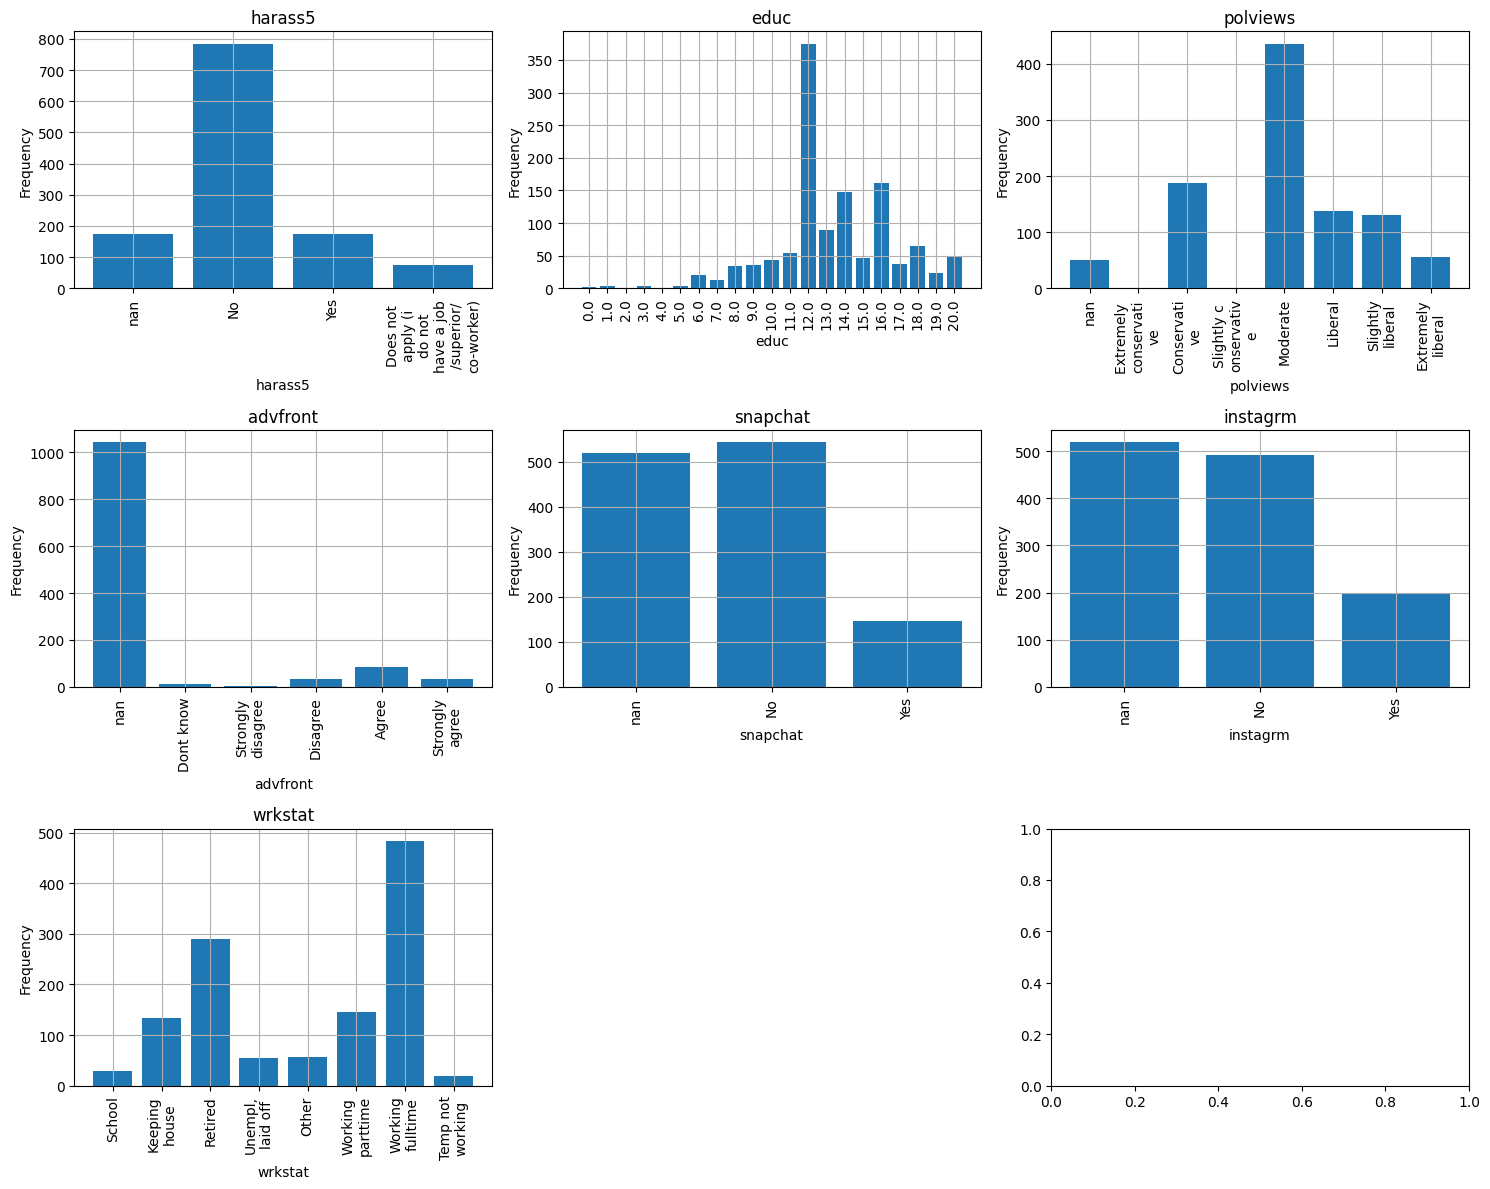

In [17]:
column_unique_value['harass5'] = [float('nan'), 'No', 'Yes', 'Does not apply (i do not have a job/superior/co-worker)']
column_unique_value['polviews'] = [float('nan'), 'Extremely conservative', 'Conservative', 'Slightly conservative', 'Moderate', 'Liberal',
                  'Slightly liberal', 'Extremely liberal']
column_unique_value['advfront'] = [float('nan'), 'Dont know', 'Strongly disagree', 'Disagree', 'Agree', 'Strongly agree']
column_unique_value['snapchat'] = [float('nan'), 'No', 'Yes']
column_unique_value['instagrm'] = [float('nan'), 'No', 'Yes']
column_unique_value['wrkstat'] = [float('nan'), 'School', 'Keeping house', 'Retired', 'Unempl, laid off', 'Other',
                 'Working parttime', 'Working fulltime', 'Temp not working']

# Get the list of categorical columns
categorical_columns = df.columns.tolist()

# Calculate the number of rows and columns needed for subplots
num_rows = (len(categorical_columns) + 2) // 3
num_cols = min(len(categorical_columns), 3)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))

# Flatten the axes array
axes = axes.ravel()

# Loop through each categorical column and create the bar plot
for i, column in enumerate(categorical_columns):
    # Count the occurrences of each value (including NaN) in the column
    #sns.countplot(x=column, data=df, ax=axes[i])
    #print("Column {}".format(column))
    if column == 'emailtotal':
        # Create a histogram for 'emailtotal'
        bins = np.linspace(0, 1000, 25)
        print("Max email minute: {}".format(np.max(df['emailtotal'])))
        axes[i].hist(df[column], bins=bins, edgecolor='black')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel("Frequency")
        axes[i].set_title(f"{column} (Histogram)")
        axes[i].grid()
    else:
        value_counts = df[column].value_counts(dropna=False, sort=False).sort_index()
        custom_order = column_unique_value.get(column, value_counts.index)
        value_counts = value_counts.reindex(custom_order)
        axes[i].bar(value_counts.index.astype(str), value_counts.values)
        wrapped_labels = [textwrap.fill(label, 10) for label in value_counts.index.astype(str)]
        axes[i].set_xticklabels(wrapped_labels, rotation=90, ha="center")
        # Set the plot labels and title for the current subplot
        axes[i].set_xlabel(column)
        axes[i].set_ylabel("Frequency")
        axes[i].set_title(f"{column}")
        axes[i].grid()

# Hide any empty subplots if needed
#if len(categorical_columns) % 3 != 0:
#    for i in range(len(categorical_columns) % 3, 3):
#        fig.delaxes(axes[-i - 1])
#
fig.delaxes(axes[-(num_rows * num_cols - len(categorical_columns))])
# Adjust layout and display the plot
plt.tight_layout()
plt.show()

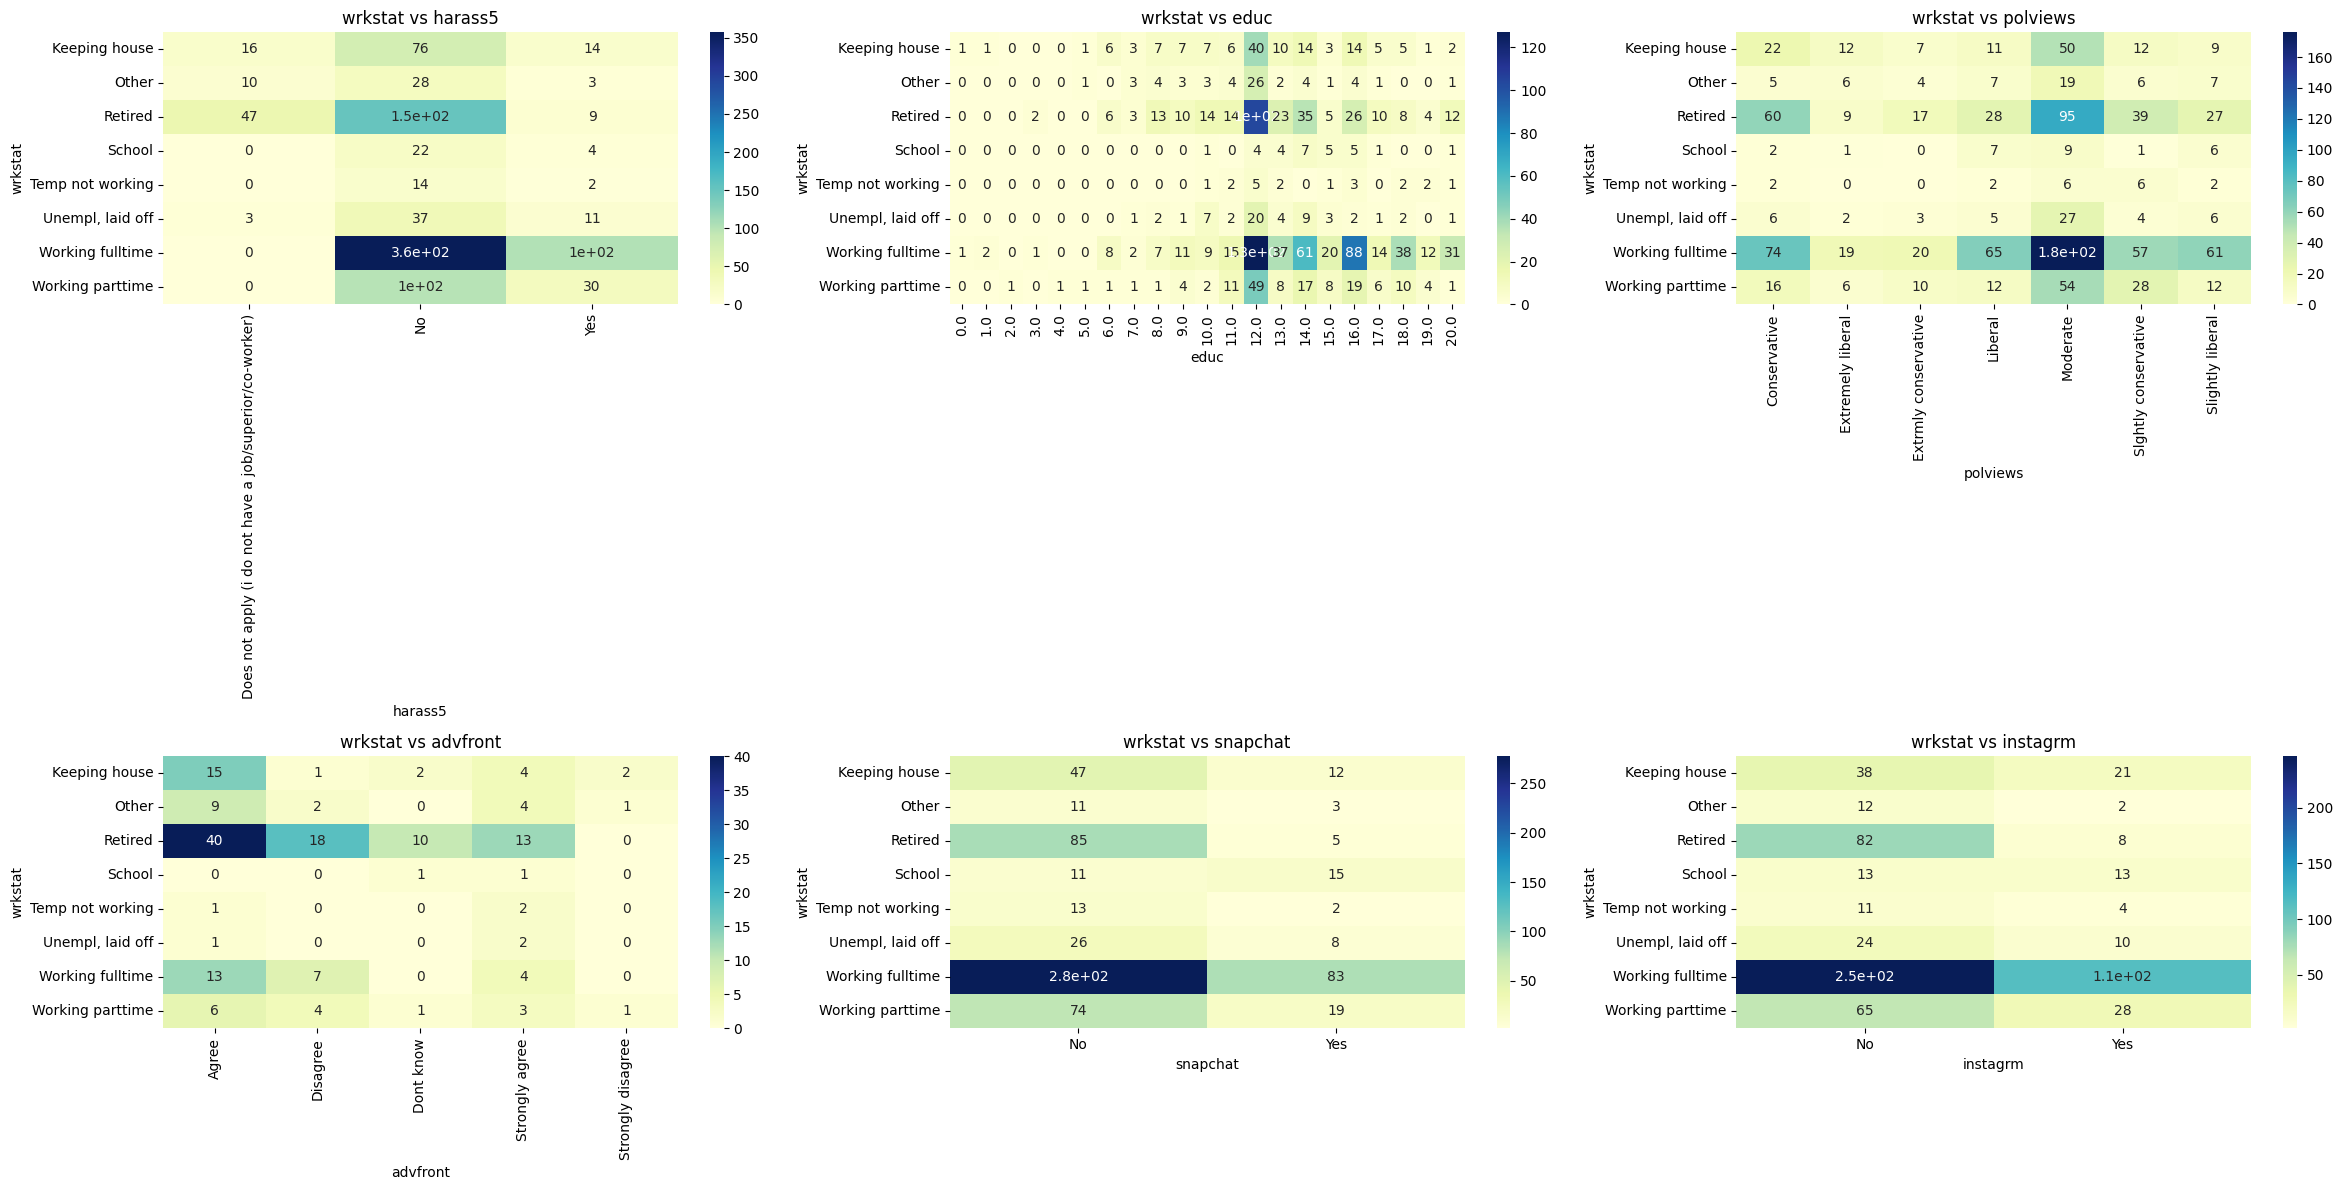

In [18]:
considered_columns = [col for col in column_unique_value if (col != 'wrkstat' and col != 'emailtotal')]

num_subplots = len(considered_columns)
num_cols = 3  # Number of subplots per row
num_rows = (num_subplots + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 6 * num_rows))

axes = axes.ravel()

for i, column in enumerate(considered_columns):
    # Create a co-occurrence matrix between 'wrkstat' and the current column
    co_occurrence_matrix = pd.crosstab(df['wrkstat'], df[column])
    # Plot the heatmap in the current subplot
    sns.heatmap(co_occurrence_matrix, annot=True, cmap='YlGnBu', cbar=True, ax=axes[i])
    axes[i].set_title(f'wrkstat vs {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('wrkstat')
    #plt.tight_layout()

for j in range(len(considered_columns), num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

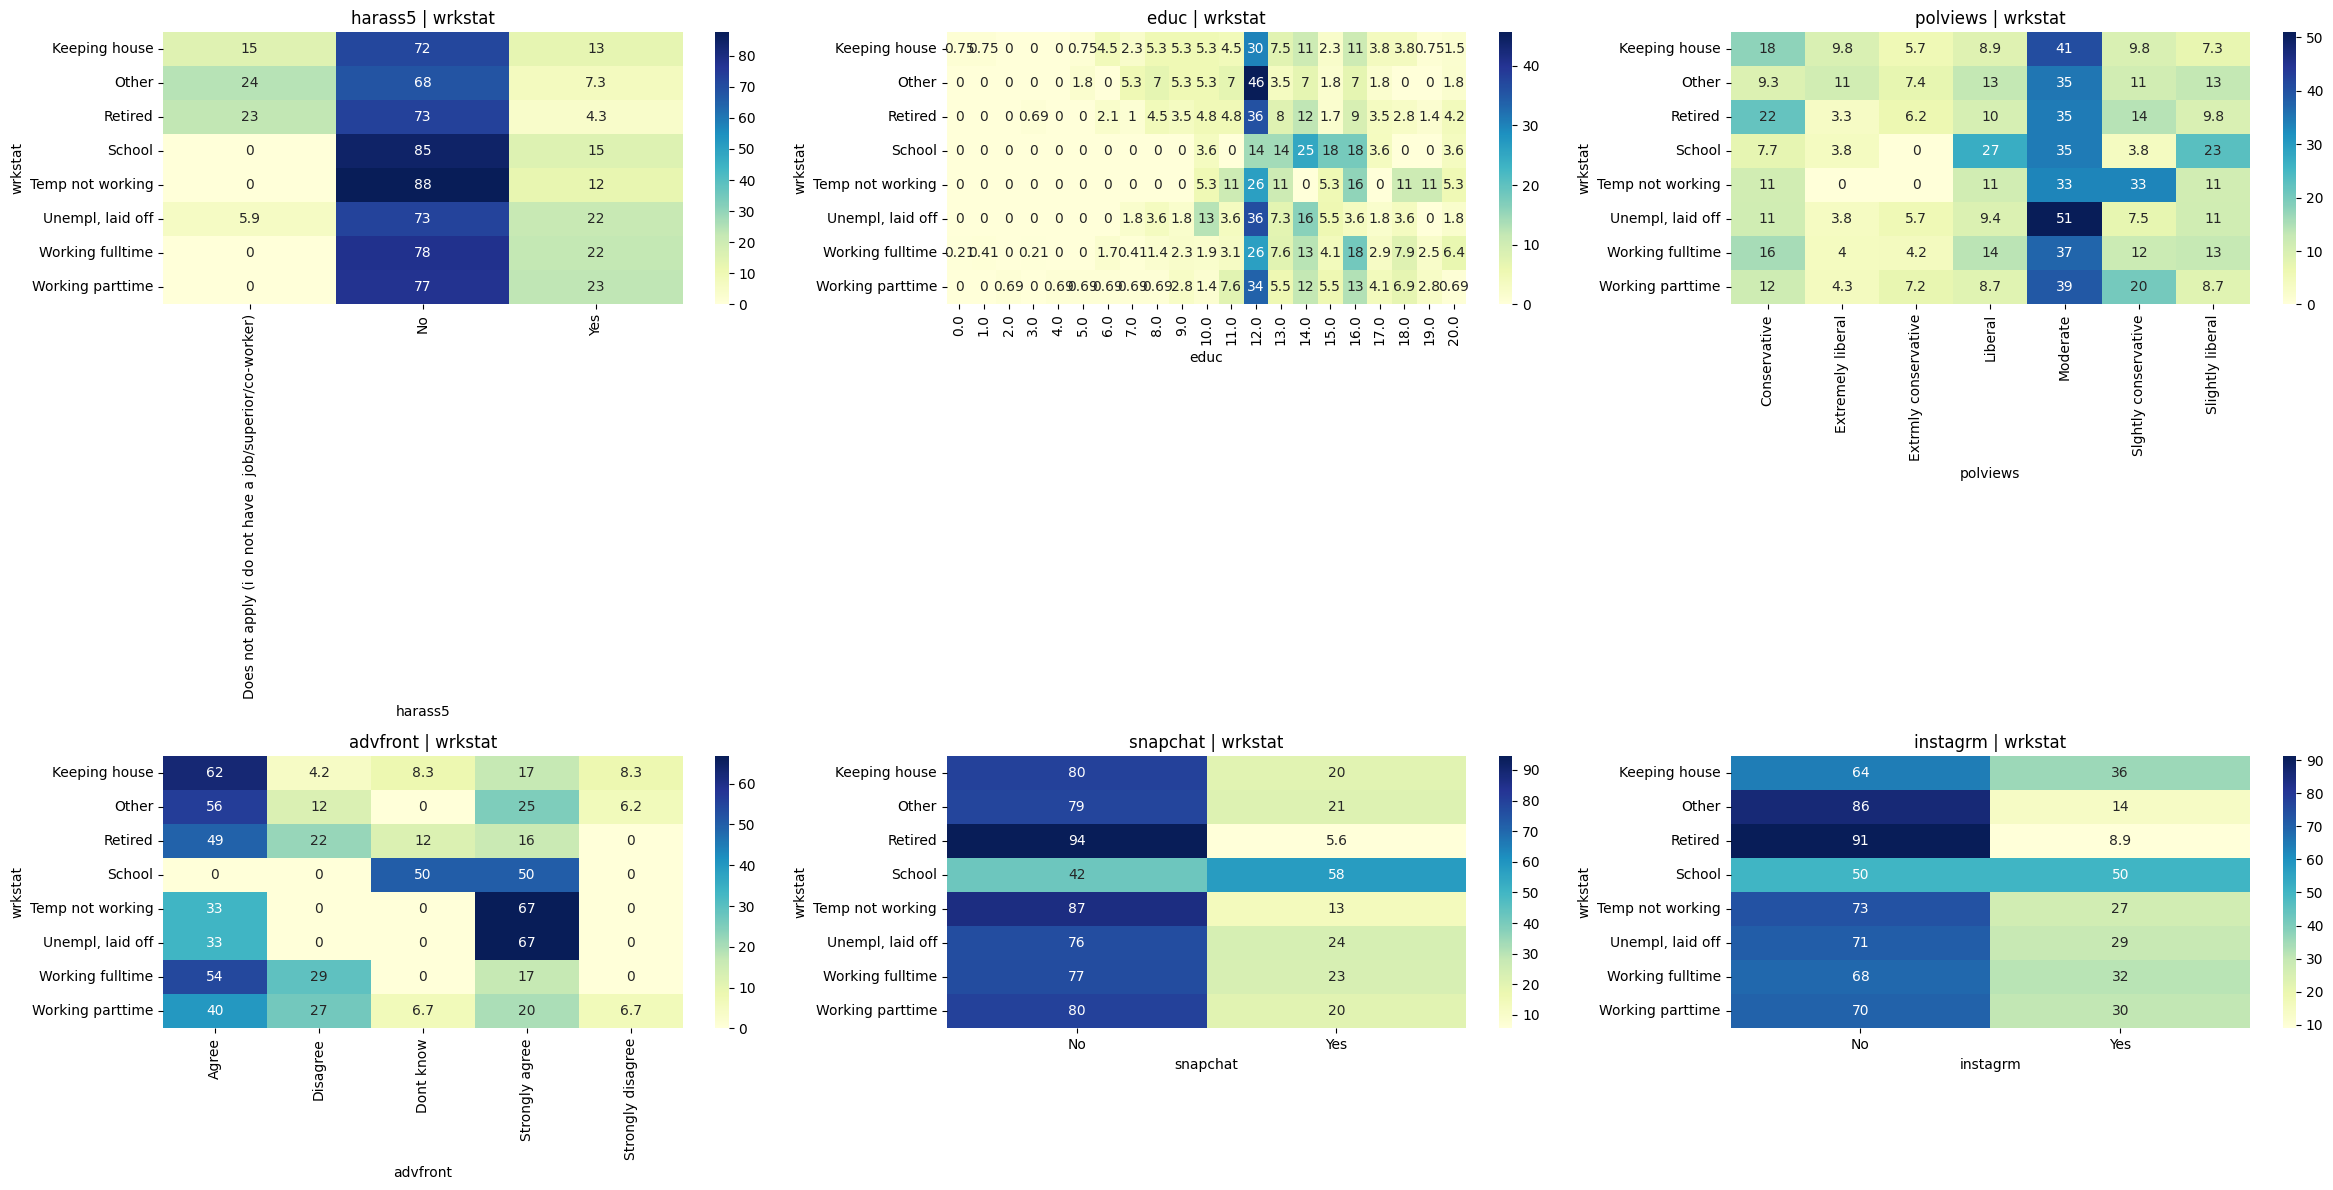

In [19]:
considered_columns = [col for col in column_unique_value if (col != 'wrkstat' and col != 'emailtotal')]

num_subplots = len(considered_columns)
num_cols = 3  # Number of subplots per row
num_rows = (num_subplots + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 6 * num_rows))

axes = axes.ravel()

for i, column in enumerate(considered_columns):
    # Create a co-occurrence matrix between 'wrkstat' and the current column
    co_occurrence_matrix = pd.crosstab(df['wrkstat'], df[column])
    percentages = co_occurrence_matrix.div(co_occurrence_matrix.sum(axis=1), axis=0) * 100
    # Plot the heatmap in the current subplot
    sns.heatmap(percentages, annot=True, cmap='YlGnBu', cbar=True, ax=axes[i])
    axes[i].set_title(f'{column} | wrkstat')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('wrkstat')
    #plt.tight_layout()
    
for j in range(len(considered_columns), num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

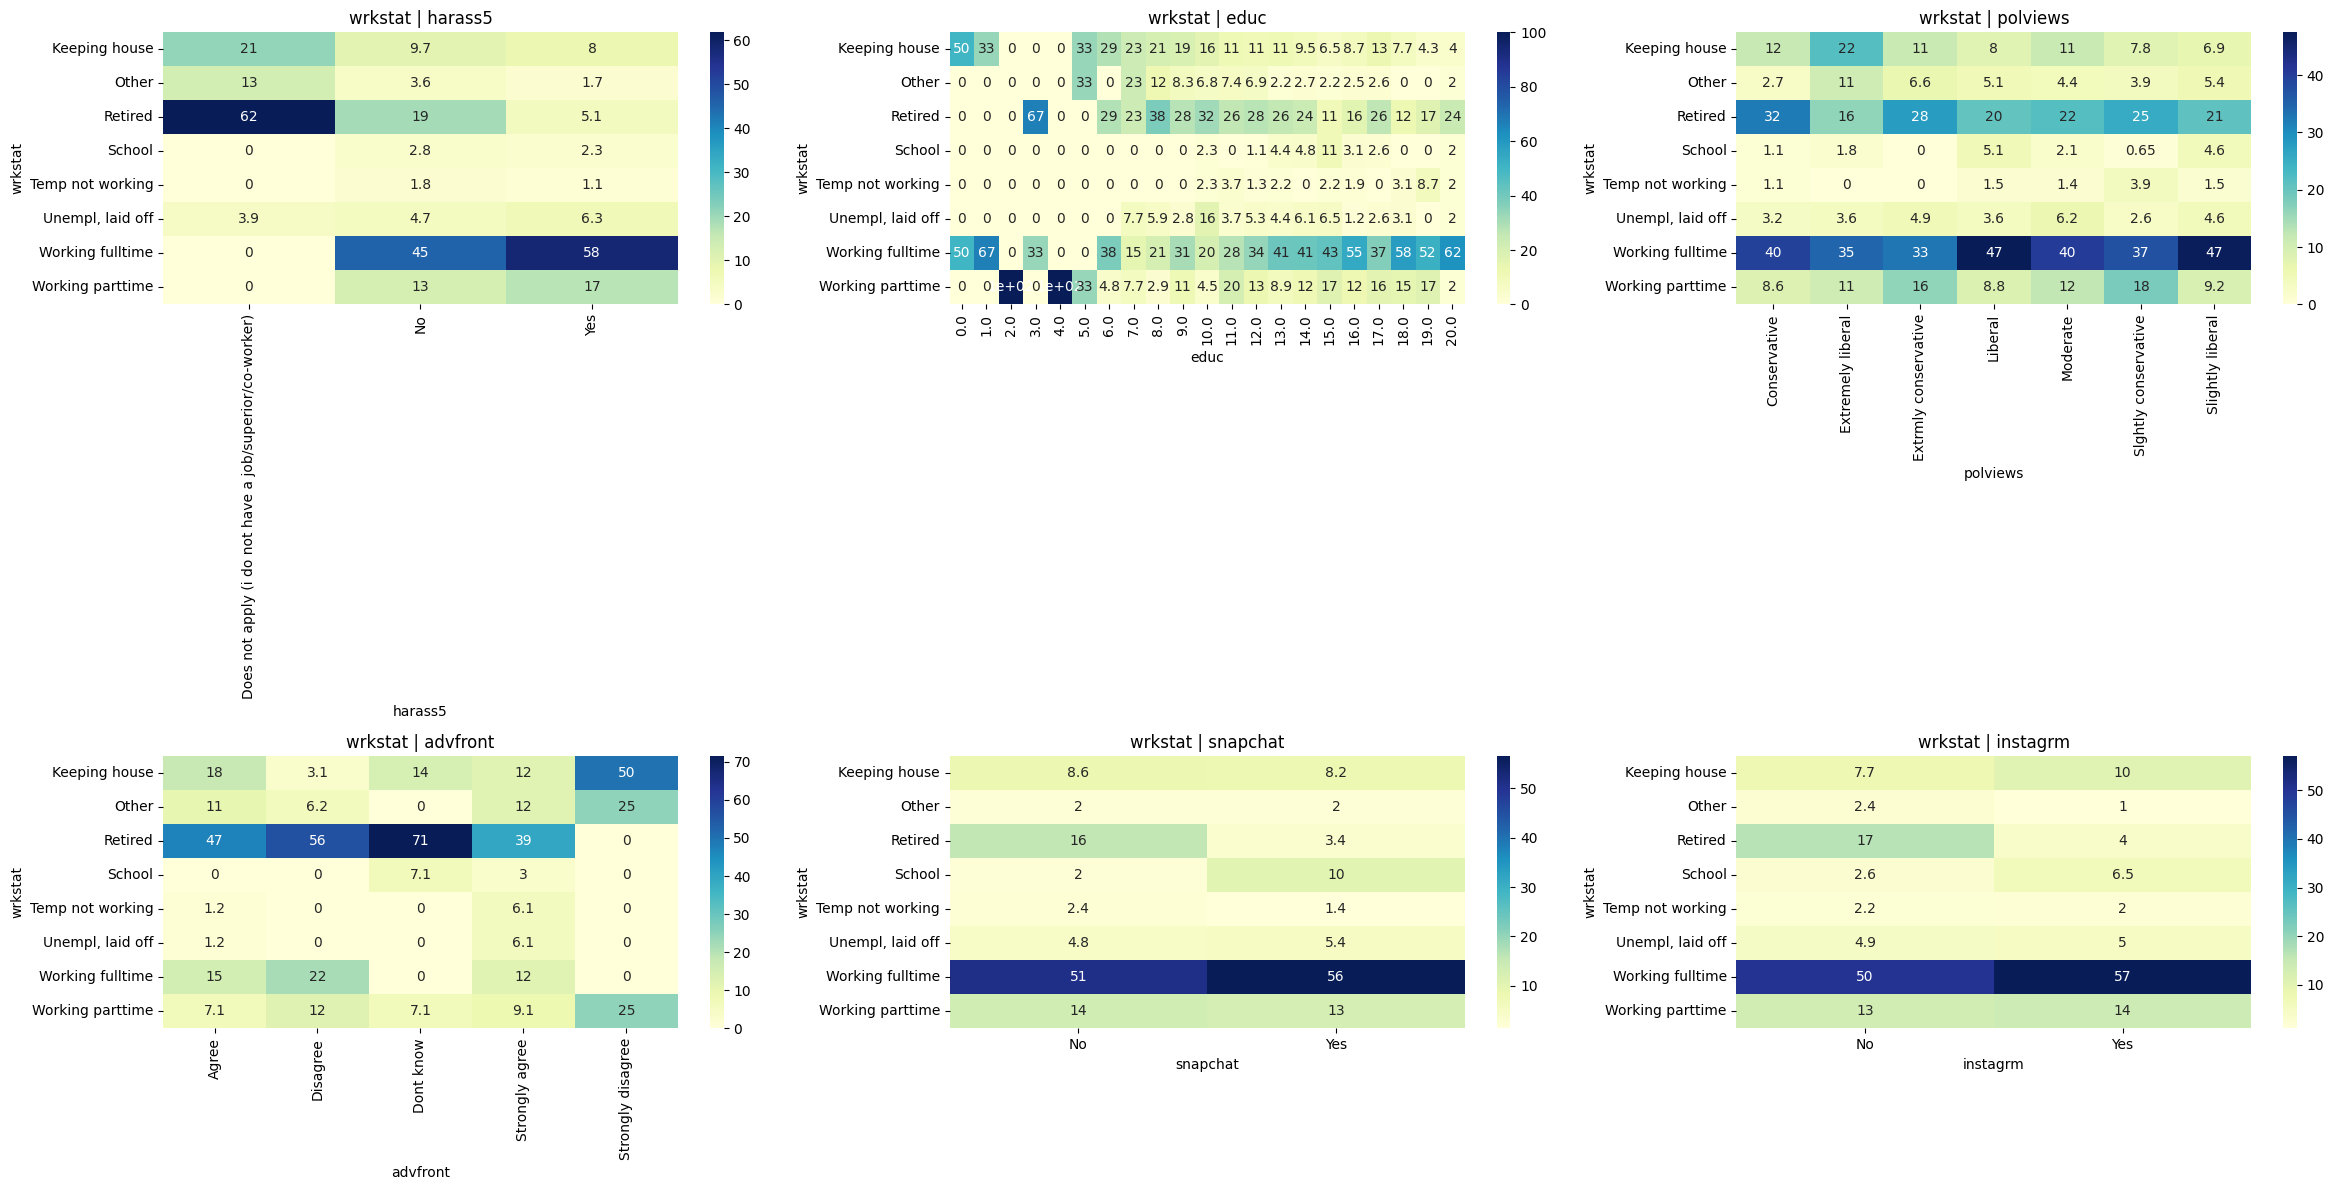

In [20]:
considered_columns = [col for col in column_unique_value if (col != 'wrkstat' and col != 'emailtotal')]

num_subplots = len(considered_columns)
num_cols = 3  # Number of subplots per row
num_rows = (num_subplots + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 6 * num_rows))

axes = axes.ravel()

for i, column in enumerate(considered_columns):
    # Create a co-occurrence matrix between 'wrkstat' and the current column
    co_occurrence_matrix = pd.crosstab(df['wrkstat'], df[column])
    percentages = co_occurrence_matrix.div(co_occurrence_matrix.sum(axis=0), axis=1) * 100
    # Plot the heatmap in the current subplot
    sns.heatmap(percentages, annot=True, cmap='YlGnBu', cbar=True, ax=axes[i])
    axes[i].set_title(f'wrkstat | {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('wrkstat')
    #plt.tight_layout()
    
for j in range(len(considered_columns), num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

In [21]:
# df_box = df[df.emailtotal < 100]
# sns.boxplot(data=df_box, x="wrkstat", y="emailtotal")
# plt.xticks(rotation=90)
# plt.grid()

In [22]:
considered = ['harass5', 'educ', 'polviews', 'advfront', 'snapchat', 'instagrm']

p_value = {}

for col in considered:
    contingency_table = pd.crosstab(df['wrkstat'], df[col])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    p_value[col] = p
    #contingency_table, chi2, p, dof, expected
    
p_value

{'harass5': 1.2848118317931192e-29,
 'educ': 9.257807566905718e-06,
 'polviews': 0.008166113318087396,
 'advfront': 0.13952623727936533,
 'snapchat': 9.874579092325339e-06,
 'instagrm': 0.00028977143784010236}

In [23]:
for col in df.columns.tolist():
    if col == 'emailtotal' or col == "wrkstat":
        continue
    df[col] = df[col].map(value_to_index[col])

In [24]:
df

,harass5,educ,polviews,advfront,snapchat,instagrm,wrkstat
2,2.0,16.0,2.0,NaN,1.0,1.0,Retired
4,2.0,18.0,5.0,NaN,2.0,2.0,Working parttime
7,2.0,11.0,3.0,NaN,2.0,2.0,Working parttime
9,2.0,14.0,2.0,NaN,1.0,1.0,Retired
11,NaN,12.0,3.0,3.0,NaN,NaN,Retired
...,...,...,...,...,...,...,...
2851,2.0,12.0,4.0,NaN,1.0,1.0,Working fulltime
2854,2.0,11.0,4.0,NaN,NaN,NaN,Retired
2859,2.0,12.0,3.0,NaN,NaN,NaN,Working parttime
2861,2.0,12.0,2.0,NaN,NaN,NaN,Retired


In [25]:
np.max(df["educ"])

20.0

In [26]:
categorical_columns = ['harass5', 'polviews', 'advfront', 'snapchat', 'instagrm', 'wrkstat']

df[categorical_columns] = df[categorical_columns].fillna(0)

df['educ'] = df['educ'].fillna(21)

#df['emailtotal'] = df['emailtotal'].fillna(0)


In [27]:
df

,harass5,educ,polviews,advfront,snapchat,instagrm,wrkstat
2,2.0,16.0,2.0,0.0,1.0,1.0,Retired
4,2.0,18.0,5.0,0.0,2.0,2.0,Working parttime
7,2.0,11.0,3.0,0.0,2.0,2.0,Working parttime
9,2.0,14.0,2.0,0.0,1.0,1.0,Retired
11,0.0,12.0,3.0,3.0,0.0,0.0,Retired
...,...,...,...,...,...,...,...
2851,2.0,12.0,4.0,0.0,1.0,1.0,Working fulltime
2854,2.0,11.0,4.0,0.0,0.0,0.0,Retired
2859,2.0,12.0,3.0,0.0,0.0,0.0,Working parttime
2861,2.0,12.0,2.0,0.0,0.0,0.0,Retired


In [28]:
#df["wrkstat"] = df["wrkstat"].astype(np.int16)
#casted_columns = ['harass5', 'educ', 'polviews', 'advfront', 'snapchat', 'instagrm', 'emailtotal']
casted_columns = ['harass5', 'educ', 'polviews', 'advfront', 'snapchat', 'instagrm']
#casted_columns = ['emailtotal']

for col in casted_columns:
    df[col] = df[col].astype(np.int16)

In [29]:
df

,harass5,educ,polviews,advfront,snapchat,instagrm,wrkstat
2,2,16,2,0,1,1,Retired
4,2,18,5,0,2,2,Working parttime
7,2,11,3,0,2,2,Working parttime
9,2,14,2,0,1,1,Retired
11,0,12,3,3,0,0,Retired
...,...,...,...,...,...,...,...
2851,2,12,4,0,1,1,Working fulltime
2854,2,11,4,0,0,0,Retired
2859,2,12,3,0,0,0,Working parttime
2861,2,12,2,0,0,0,Retired


In [30]:
categorical_columns = ['harass5', 'snapchat', 'instagrm', 'polviews', 'advfront', 'educ']
#numerical_columns = ['emailtotal']

df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=False)
#scaler = MinMaxScaler()
#scaler = StandardScaler()

#df_encoded[numerical_columns] = scaler.fit_transform(df_encoded[numerical_columns])
#df_encoded = scaler.fit_transform(df_encoded)

df_encoded

,wrkstat,harass5_0,harass5_1,harass5_2,harass5_3,snapchat_0,snapchat_1,snapchat_2,instagrm_0,instagrm_1,...,educ_11,educ_12,educ_13,educ_14,educ_15,educ_16,educ_17,educ_18,educ_19,educ_20
2,Retired,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,Working parttime,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
7,Working parttime,0,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
9,Retired,0,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
11,Retired,1,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2851,Working fulltime,0,0,1,0,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2854,Retired,0,0,1,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2859,Working parttime,0,0,1,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2861,Retired,0,0,1,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [31]:
y = df_encoded["wrkstat"]
y = y.to_numpy()

x = df_encoded.drop("wrkstat", axis=1).to_numpy()
U, reduced_x = pca(x=x, alpha=0.4)

# pca = PCA(n_components=3)
# pca.fit(x)
# reduced_x = pca.transform(x)

x.shape, y, reduced_x

((1210, 45),
 array(['Retired', 'Working parttime', 'Working parttime', ...,
        'Working parttime', 'Retired', 'Retired'], dtype=object),
 array([[ 1.30435   ,  0.46552921,  0.28922308],
        [ 0.60632419,  1.35262702, -0.48602664],
        [ 0.5626903 ,  1.33346182, -0.48373106],
        ...,
        [-0.64536006,  1.17042439,  0.69260063],
        [-0.68966536,  1.249954  ,  0.62442762],
        [ 1.3486553 ,  0.38599959,  0.35739608]]))

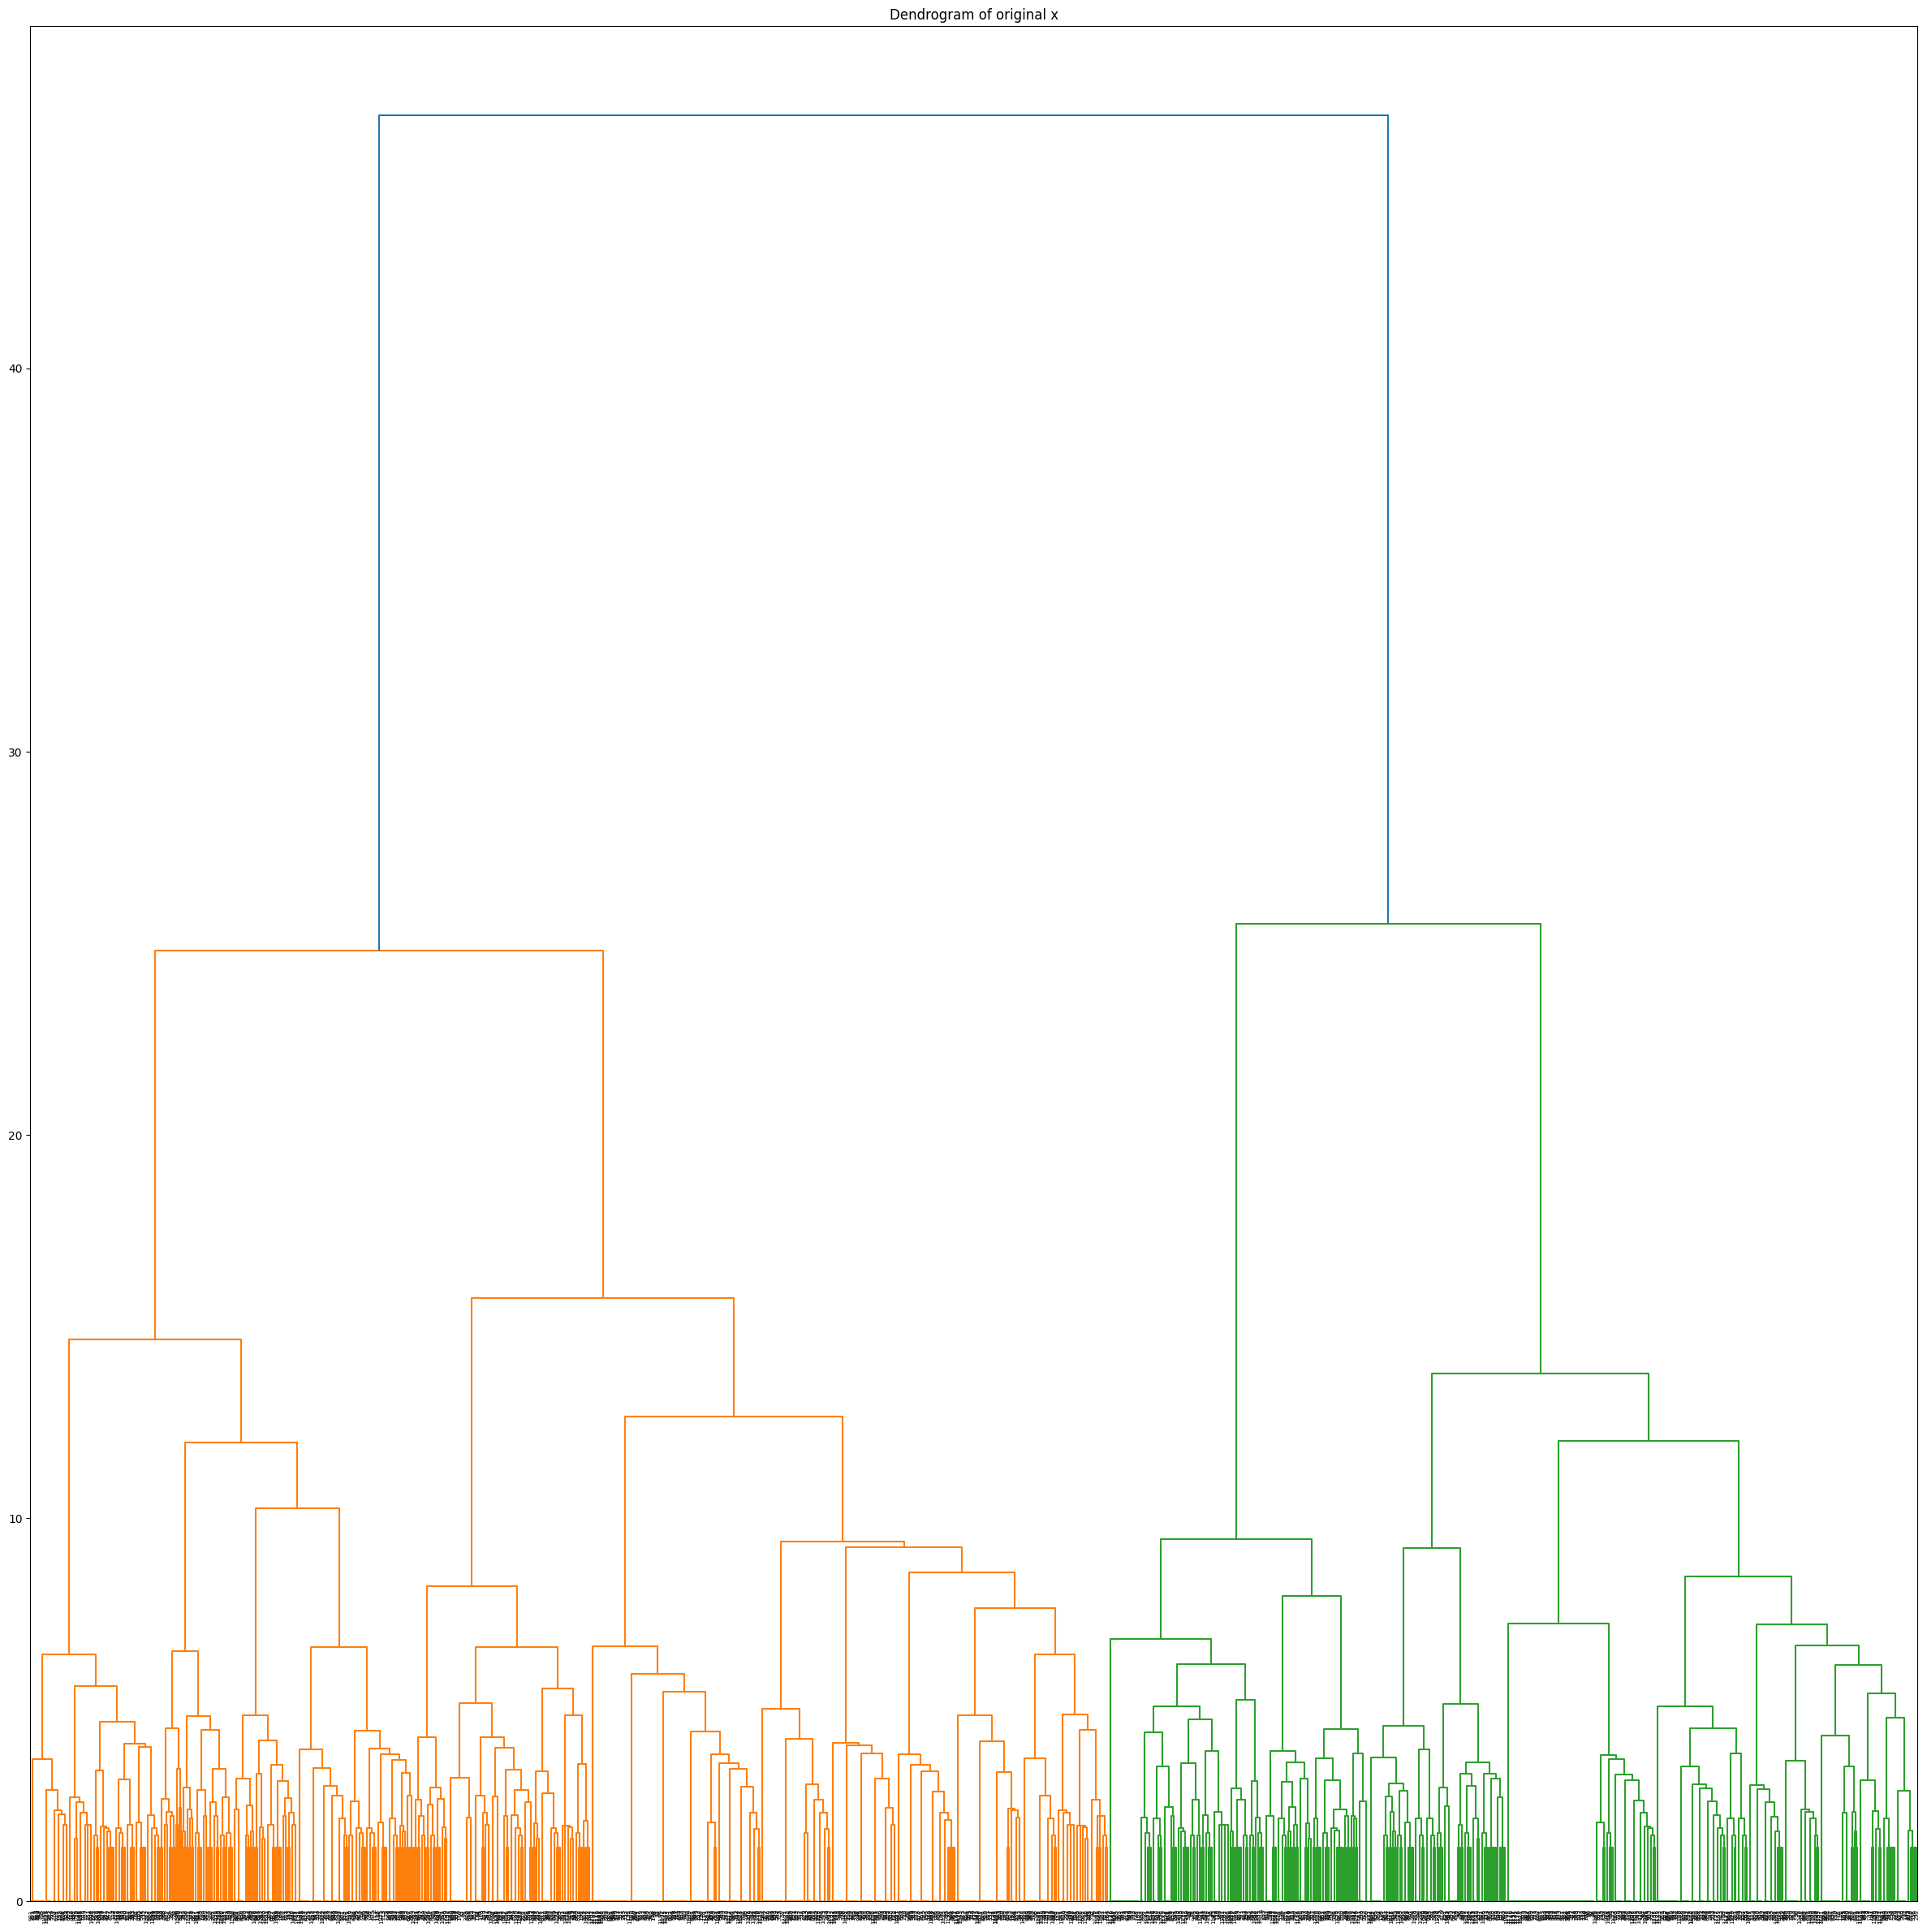

In [32]:
z = hierarchy.linkage(x, "ward")
plt.figure(figsize=(30, 30))
plt.title("Dendrogram of original x")
dn = hierarchy.dendrogram(z)

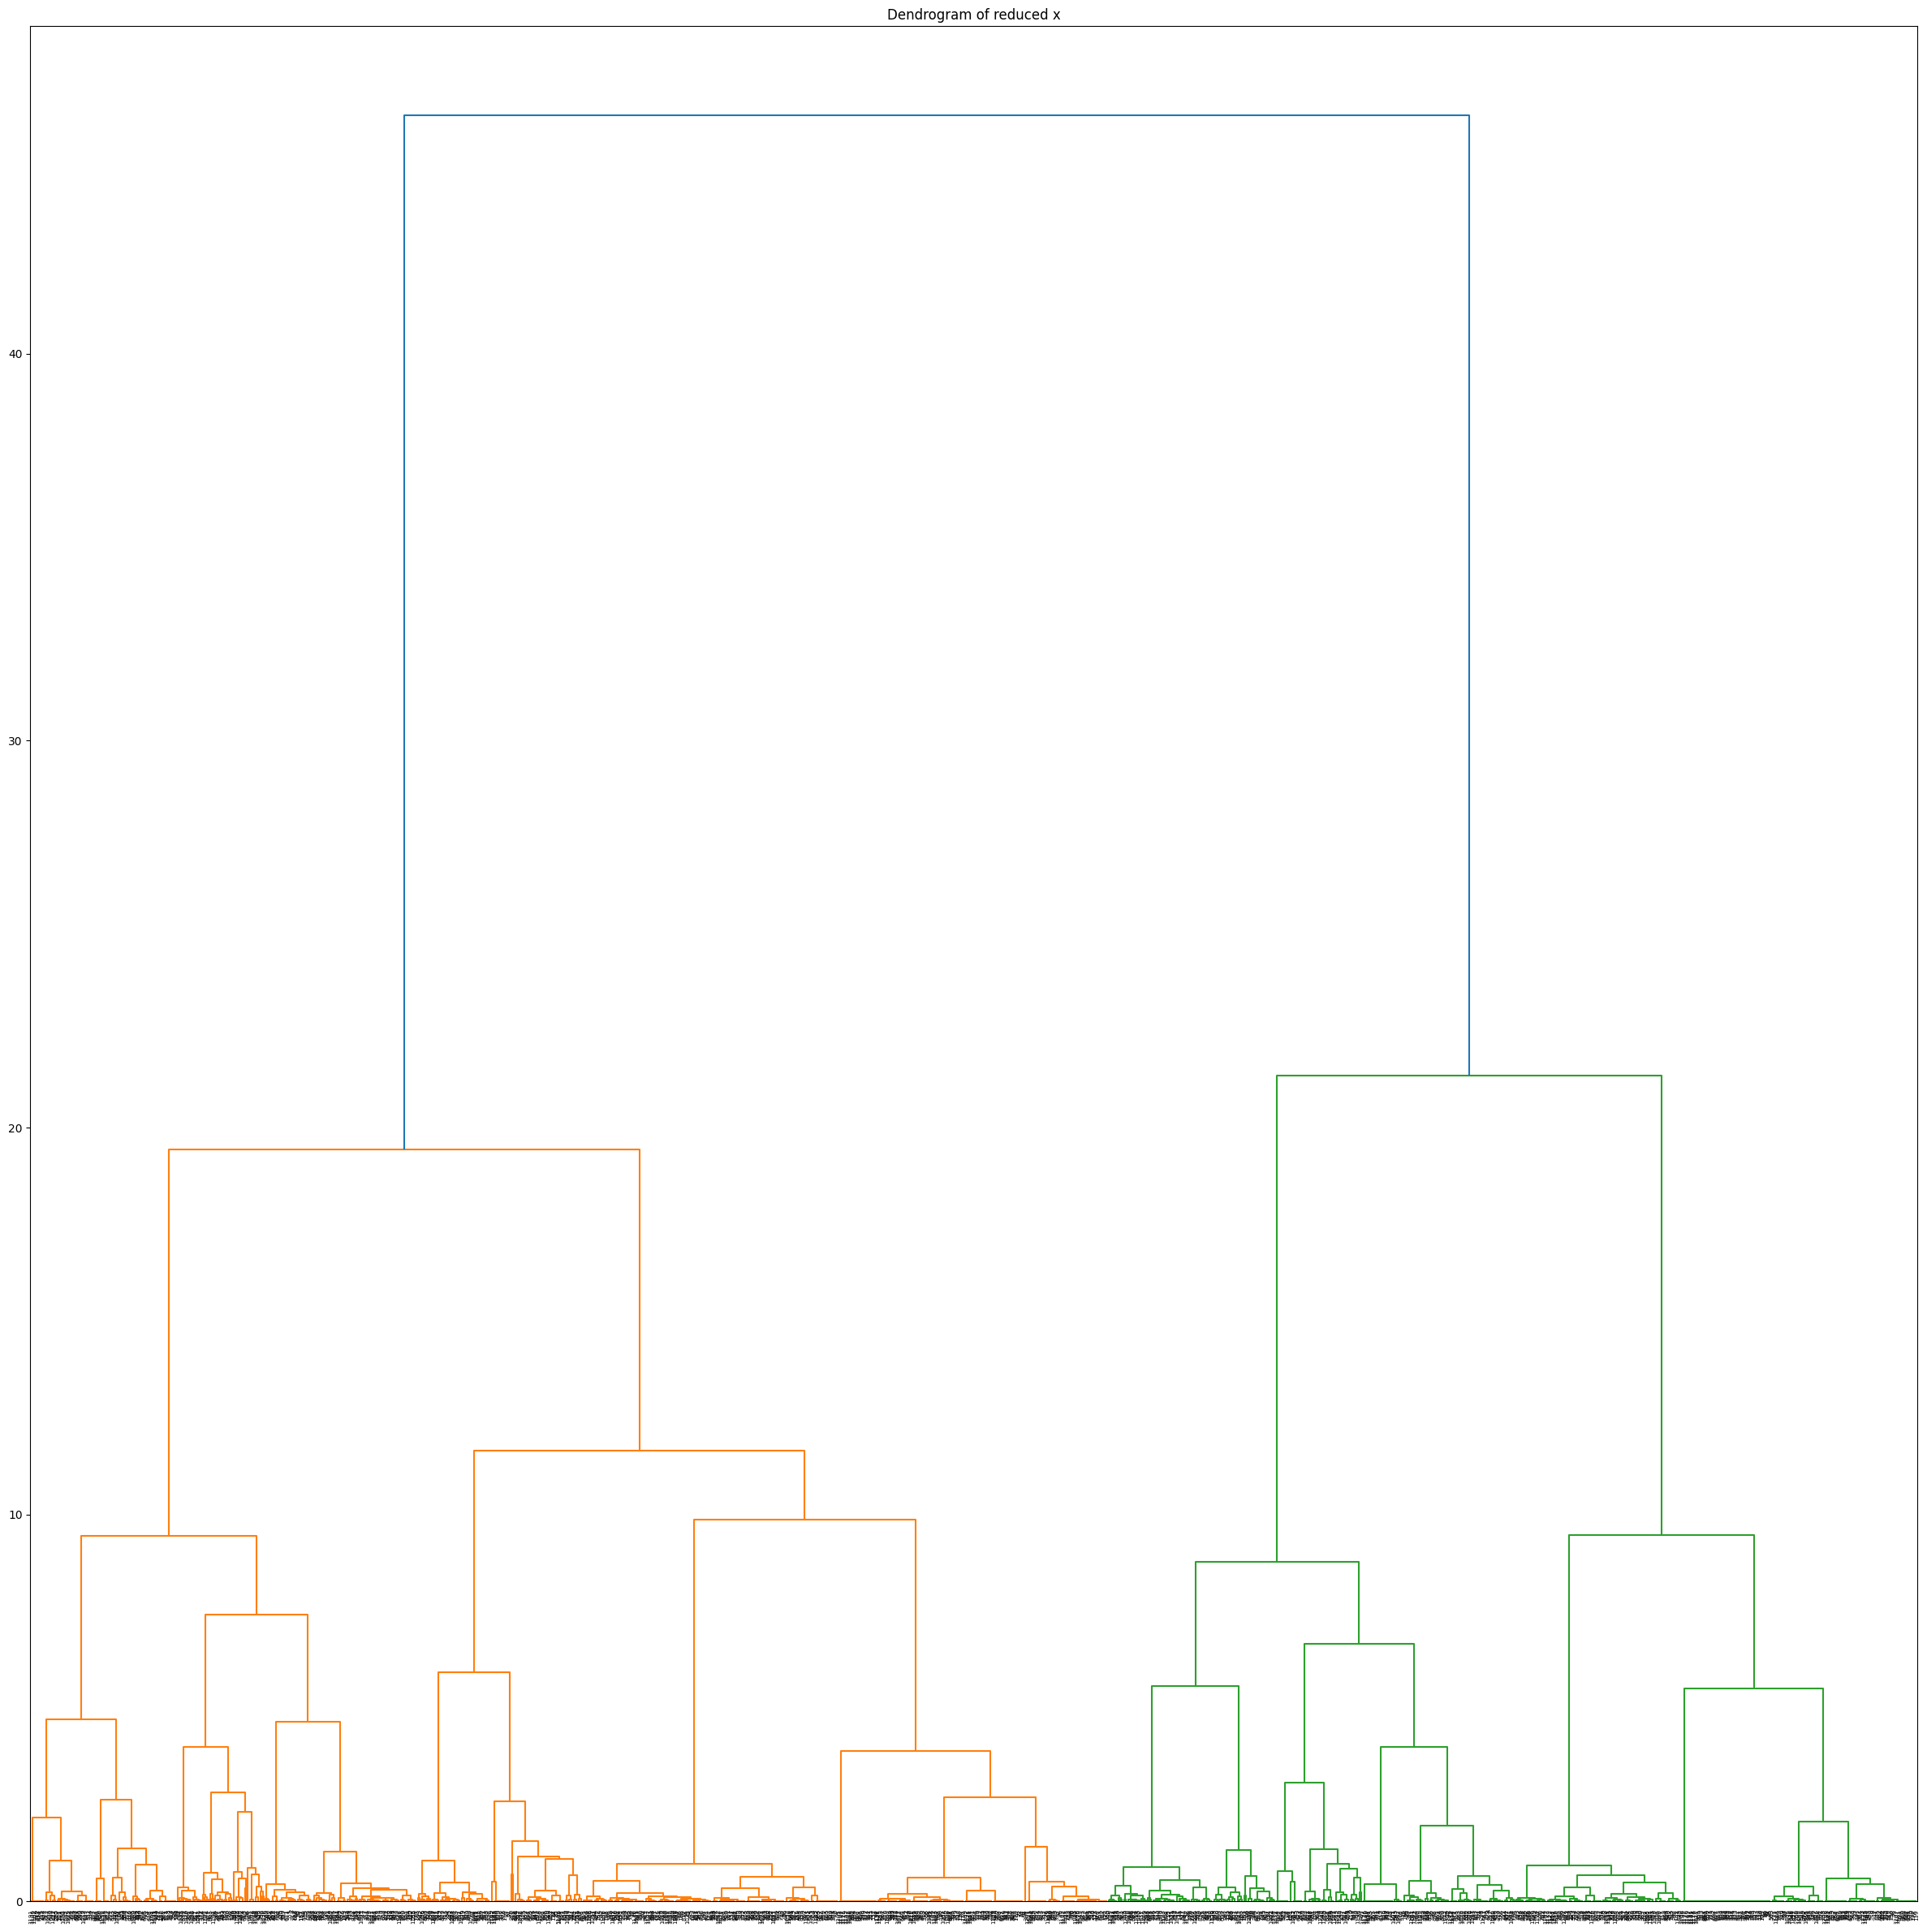

In [33]:
reduced_z = hierarchy.linkage(reduced_x, "ward")
plt.figure(figsize=(30, 30))
plt.title("Dendrogram of reduced x")
dn = hierarchy.dendrogram(reduced_z)

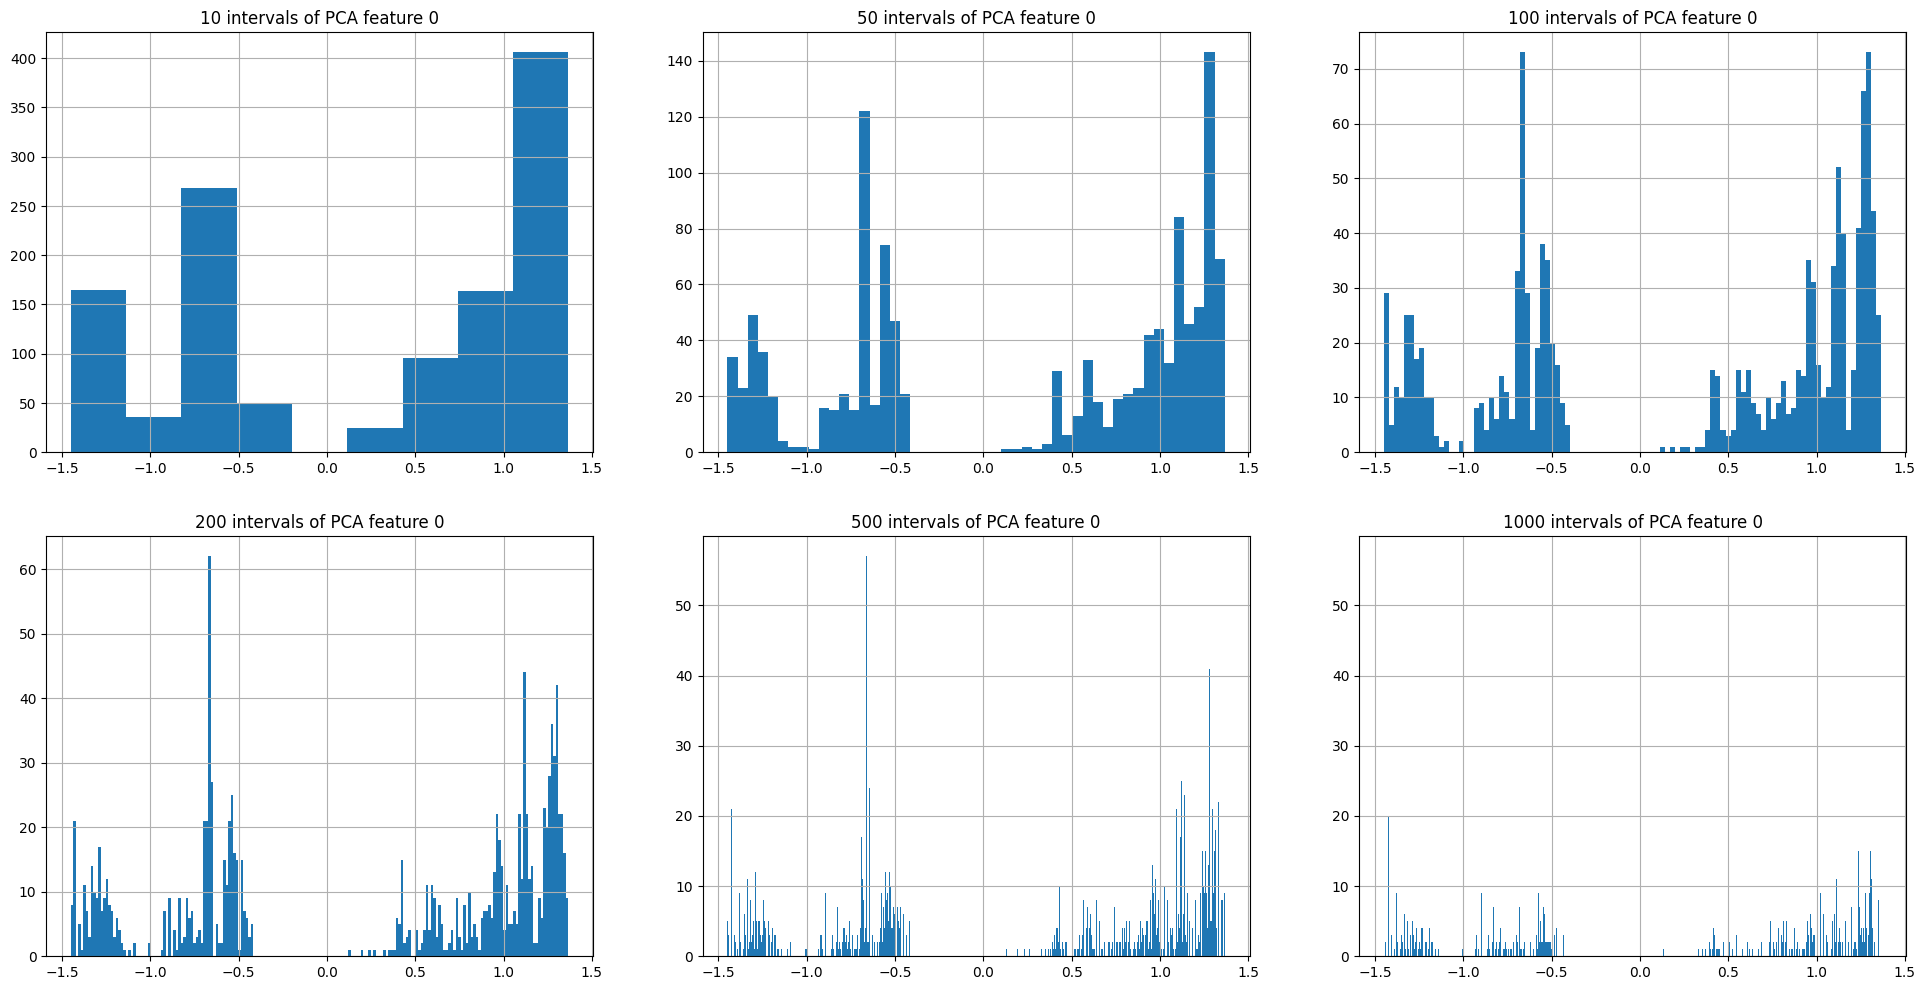

In [34]:
#np.min(reduced_x[:, 0]), np.max(reduced_x[:, 0])

num_points = [10, 50, 100, 200, 500, 1000]

num_rows = (len(num_points) + 2) // 3
num_cols = min(len(num_points), 3)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 6 * num_rows))

axes = axes.ravel()

dim = 0

dominant_dim = reduced_x[:, dim]

for i, n_point in enumerate(num_points):
    bins = np.linspace(np.min(dominant_dim), np.max(dominant_dim), n_point)
    axes[i].hist(dominant_dim, bins)
    axes[i].set_title('{} intervals of PCA feature {}'.format(n_point, dim))
    axes[i].grid()
    
for j in range(len(num_points), num_rows * num_cols):
    fig.delaxes(axes[j])

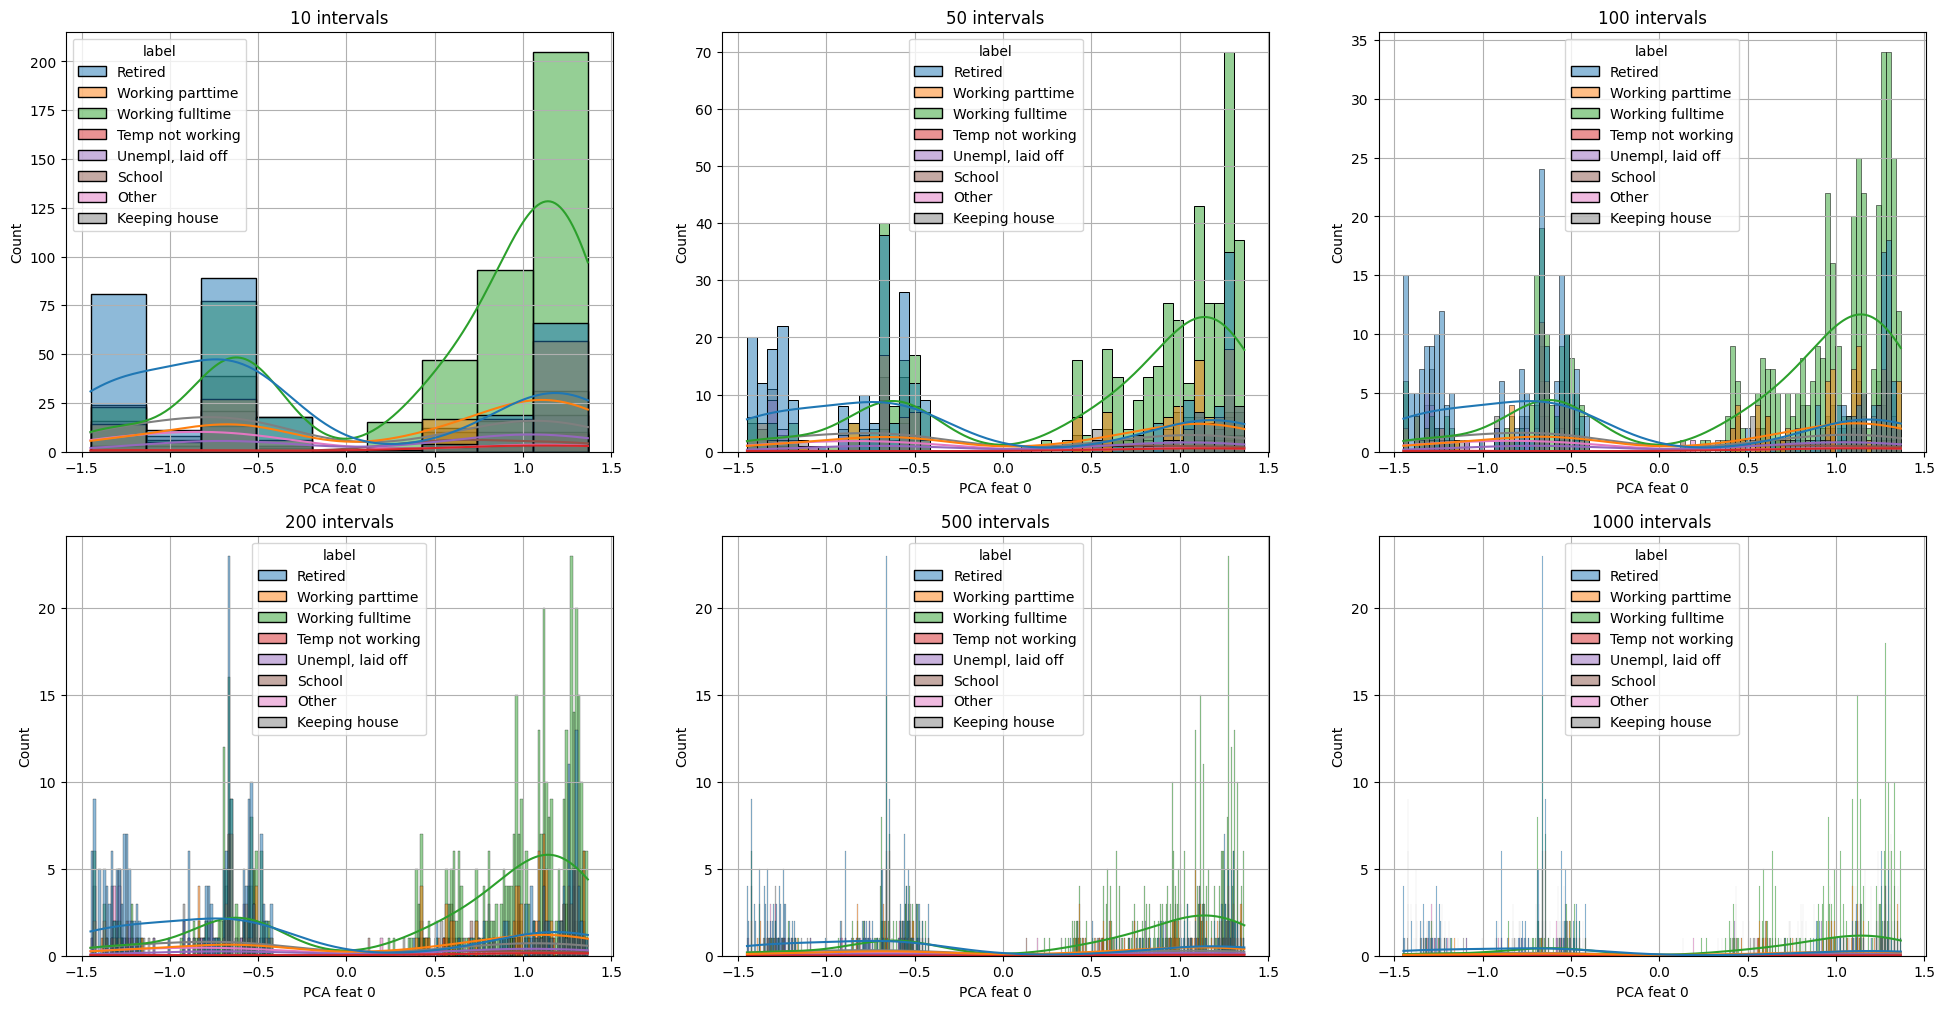

In [35]:
num_points = [10, 50, 100, 200, 500, 1000]

num_rows = (len(num_points) + 2) // 3
num_cols = min(len(num_points), 3)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 6 * num_rows))

axes = axes.ravel()

dim = 0

dominant_dim = reduced_x[:, dim]
temp_df = pd.DataFrame({"PCA feat {}".format(dim): dominant_dim, "label": y})

for i, n_point in enumerate(num_points):
    bins = np.linspace(np.min(dominant_dim), np.max(dominant_dim), n_point)
    sns.histplot(data=temp_df, x="PCA feat {}".format(dim), hue='label', bins=bins, kde=True, ax=axes[i])
    axes[i].set_title('{} intervals'.format(n_point))
    axes[i].grid()
    
for j in range(len(num_points), num_rows * num_cols):
    fig.delaxes(axes[j])


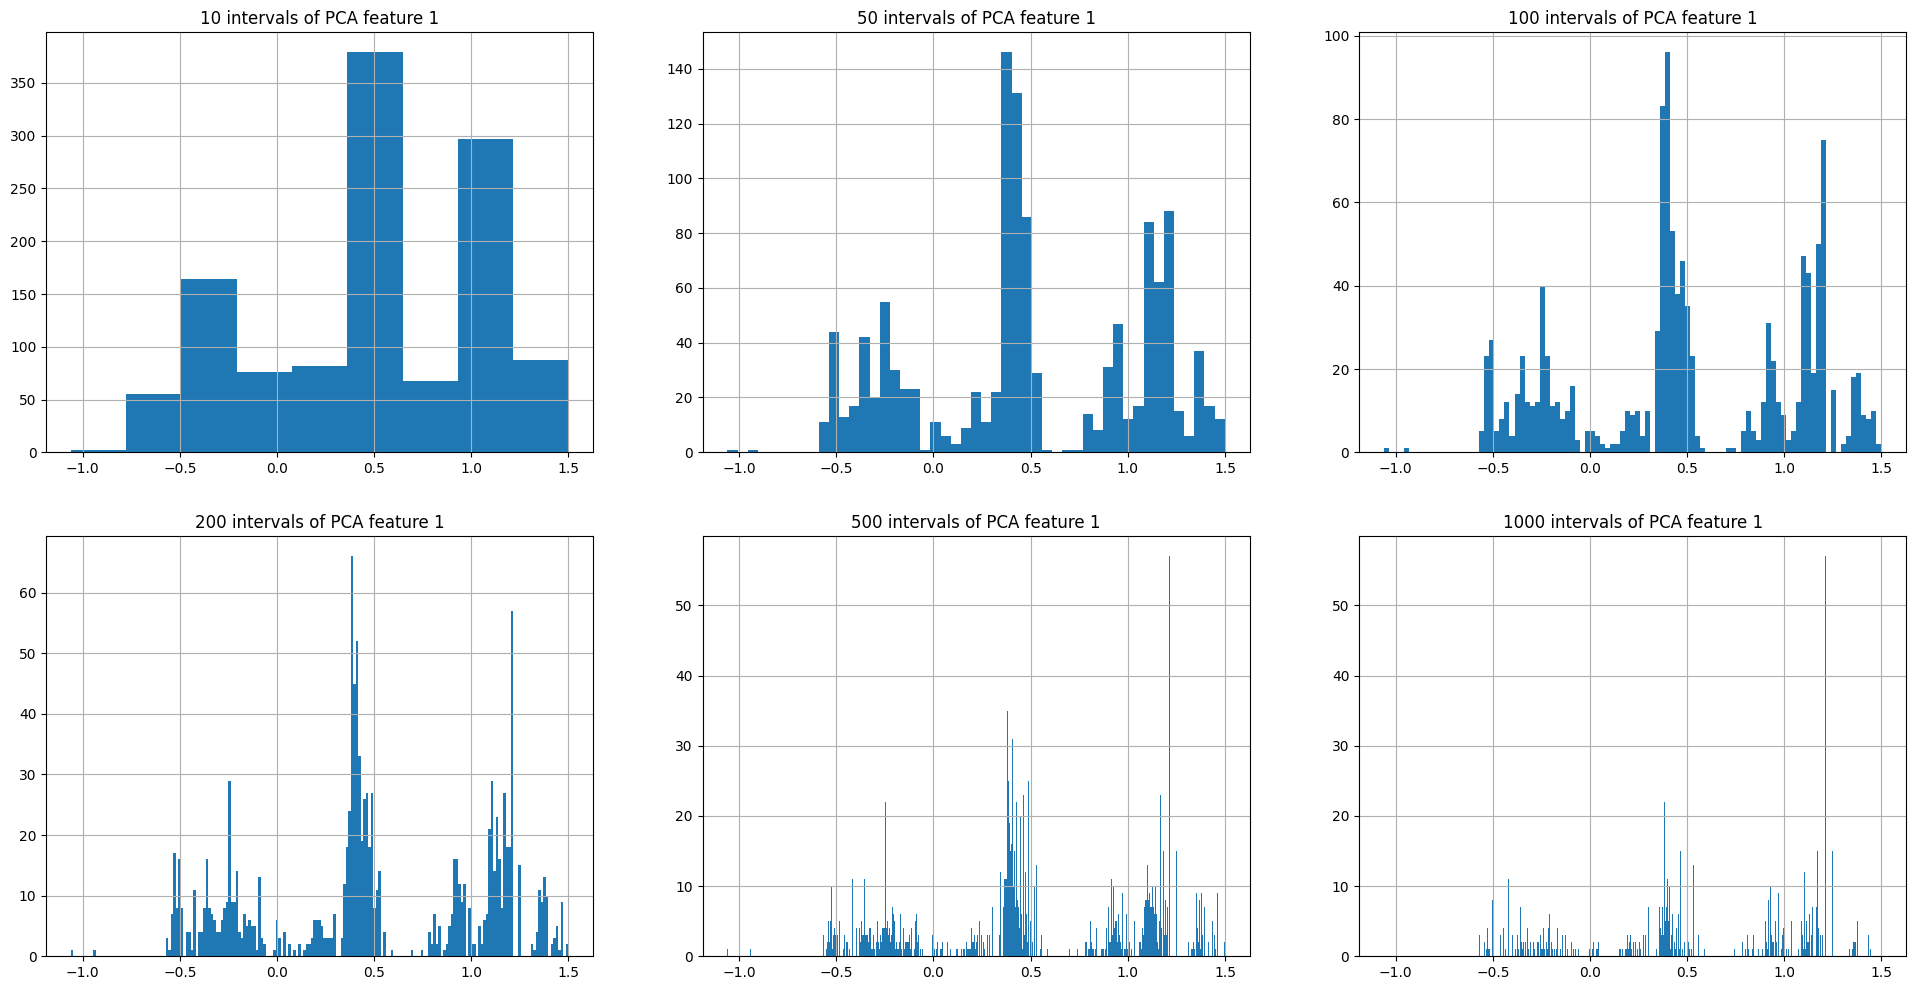

In [36]:
#np.min(reduced_x[:, 0]), np.max(reduced_x[:, 0])
num_points = [10, 50, 100, 200, 500, 1000]

num_rows = (len(num_points) + 2) // 3
num_cols = min(len(num_points), 3)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 6 * num_rows))

axes = axes.ravel()

dim = 1

dominant_dim = reduced_x[:, dim]

for i, n_point in enumerate(num_points):
    bins = np.linspace(np.min(dominant_dim), np.max(dominant_dim), n_point)
    axes[i].hist(dominant_dim, bins)
    axes[i].set_title('{} intervals of PCA feature {}'.format(n_point, dim))
    axes[i].grid()
    
for j in range(len(num_points), num_rows * num_cols):
    fig.delaxes(axes[j])

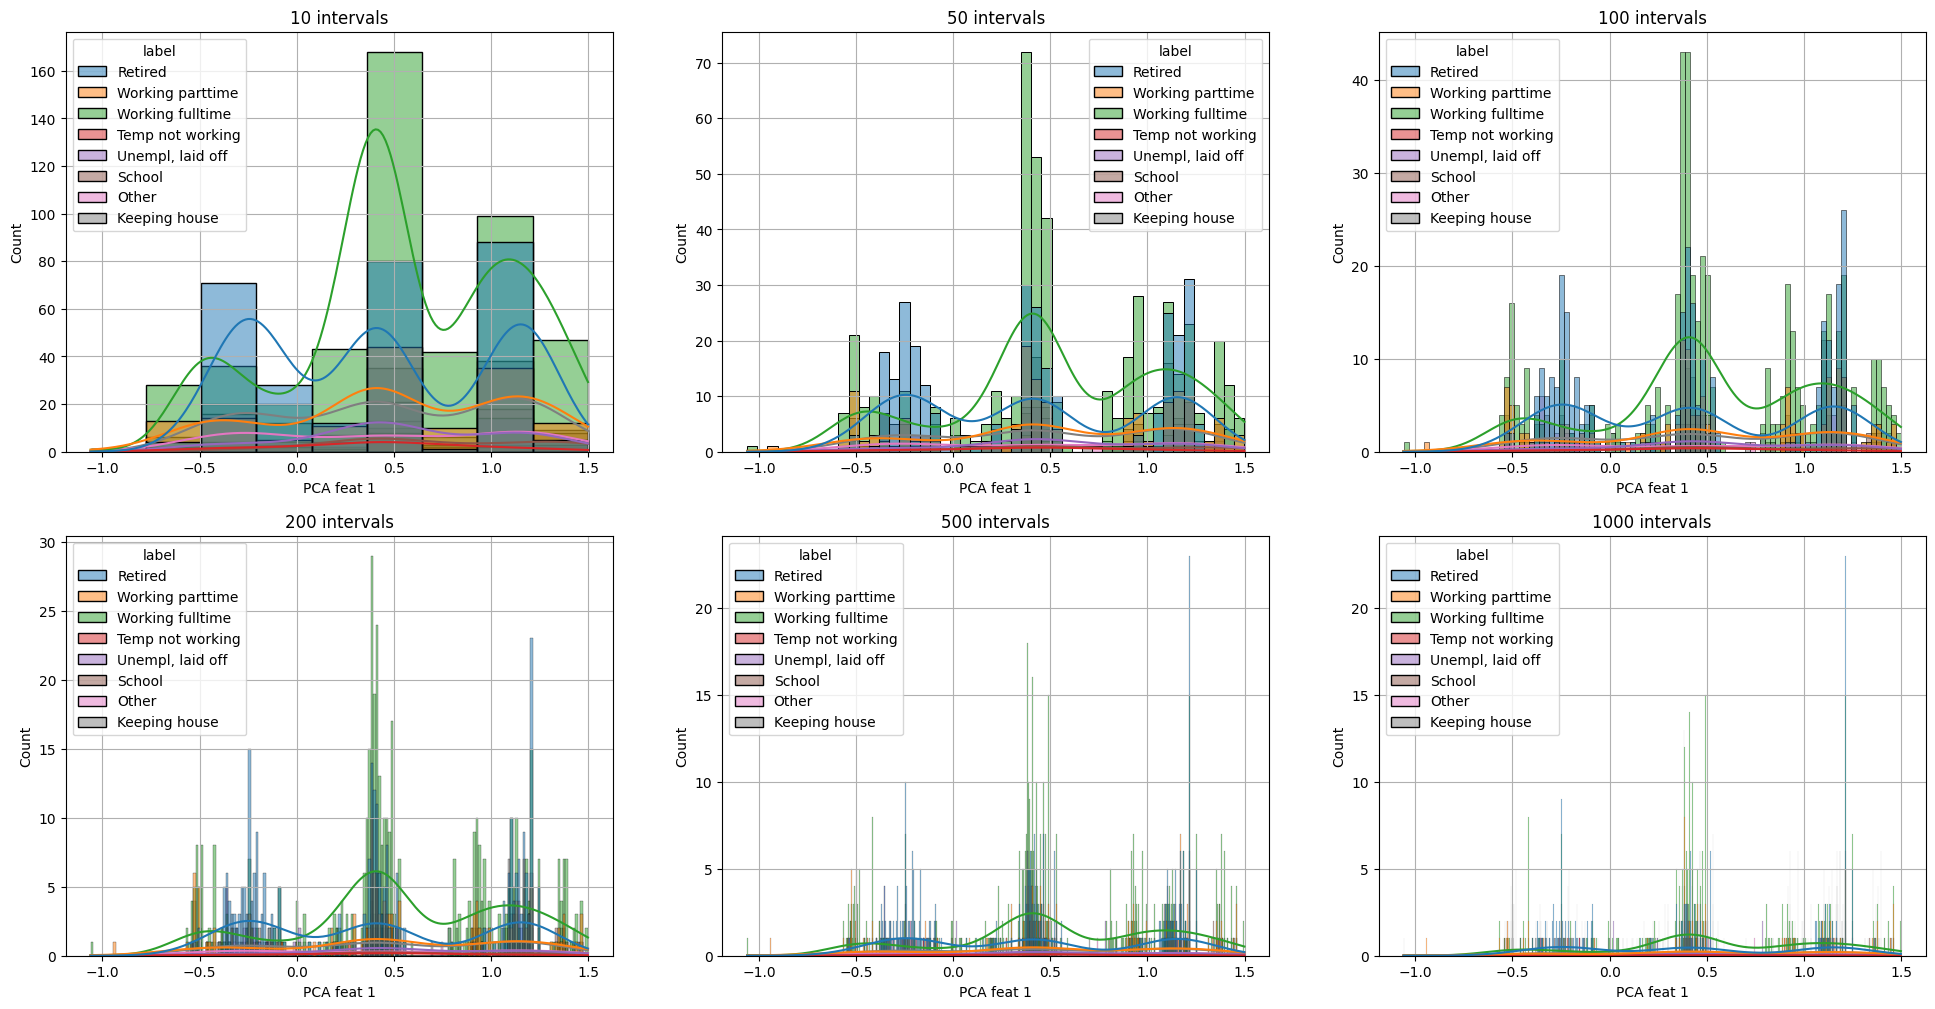

In [37]:
num_points = [10, 50, 100, 200, 500, 1000]

num_rows = (len(num_points) + 2) // 3
num_cols = min(len(num_points), 3)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 6 * num_rows))

axes = axes.ravel()

dim = 1

dominant_dim = reduced_x[:, dim]
temp_df = pd.DataFrame({"PCA feat {}".format(dim): dominant_dim, "label": y})

for i, n_point in enumerate(num_points):
    bins = np.linspace(np.min(dominant_dim), np.max(dominant_dim), n_point)
    sns.histplot(data=temp_df, x="PCA feat {}".format(dim), hue='label', bins=bins, kde=True, ax=axes[i])
    axes[i].set_title('{} intervals'.format(n_point))
    axes[i].grid()
    
for j in range(len(num_points), num_rows * num_cols):
    fig.delaxes(axes[j])

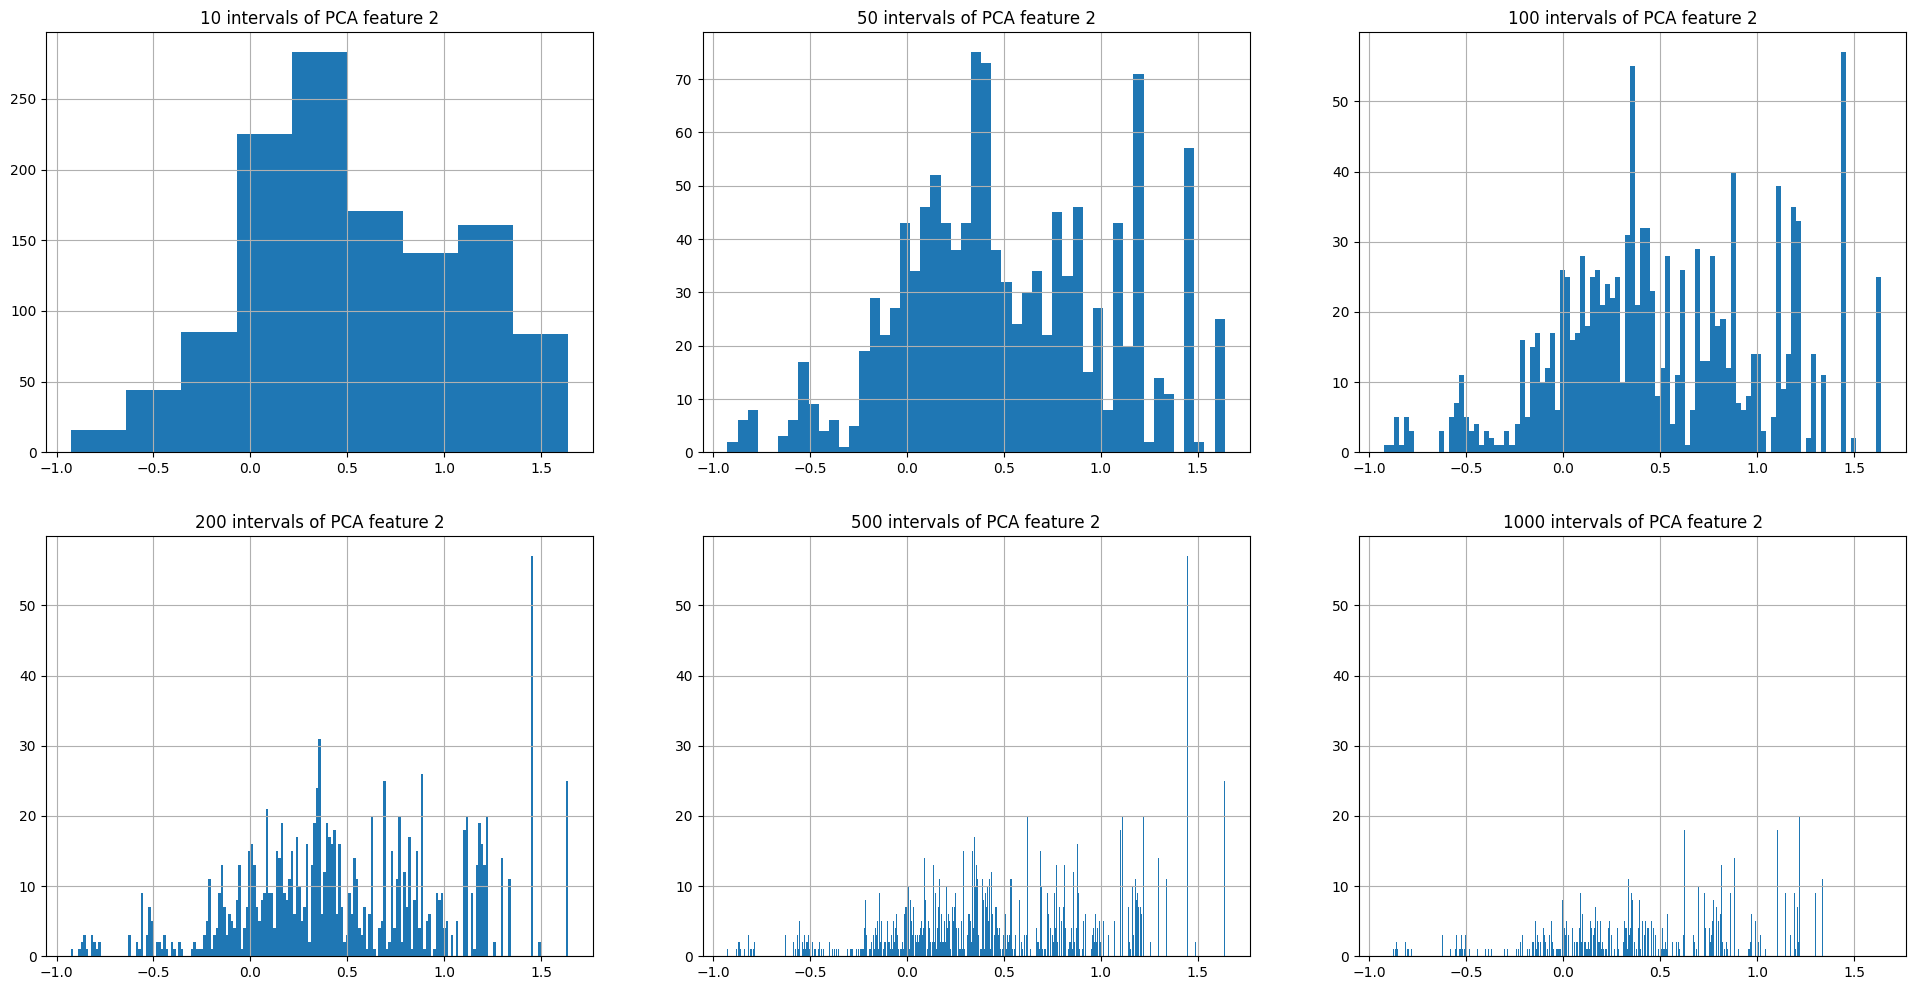

In [38]:
#np.min(reduced_x[:, 0]), np.max(reduced_x[:, 0])
num_points = [10, 50, 100, 200, 500, 1000]

num_rows = (len(num_points) + 2) // 3
num_cols = min(len(num_points), 3)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 6 * num_rows))

axes = axes.ravel()

dim = 2

dominant_dim = reduced_x[:, dim]

for i, n_point in enumerate(num_points):
    bins = np.linspace(np.min(dominant_dim), np.max(dominant_dim), n_point)
    axes[i].hist(dominant_dim, bins)
    axes[i].set_title('{} intervals of PCA feature {}'.format(n_point, dim))
    axes[i].grid()
    
for j in range(len(num_points), num_rows * num_cols):
    fig.delaxes(axes[j])

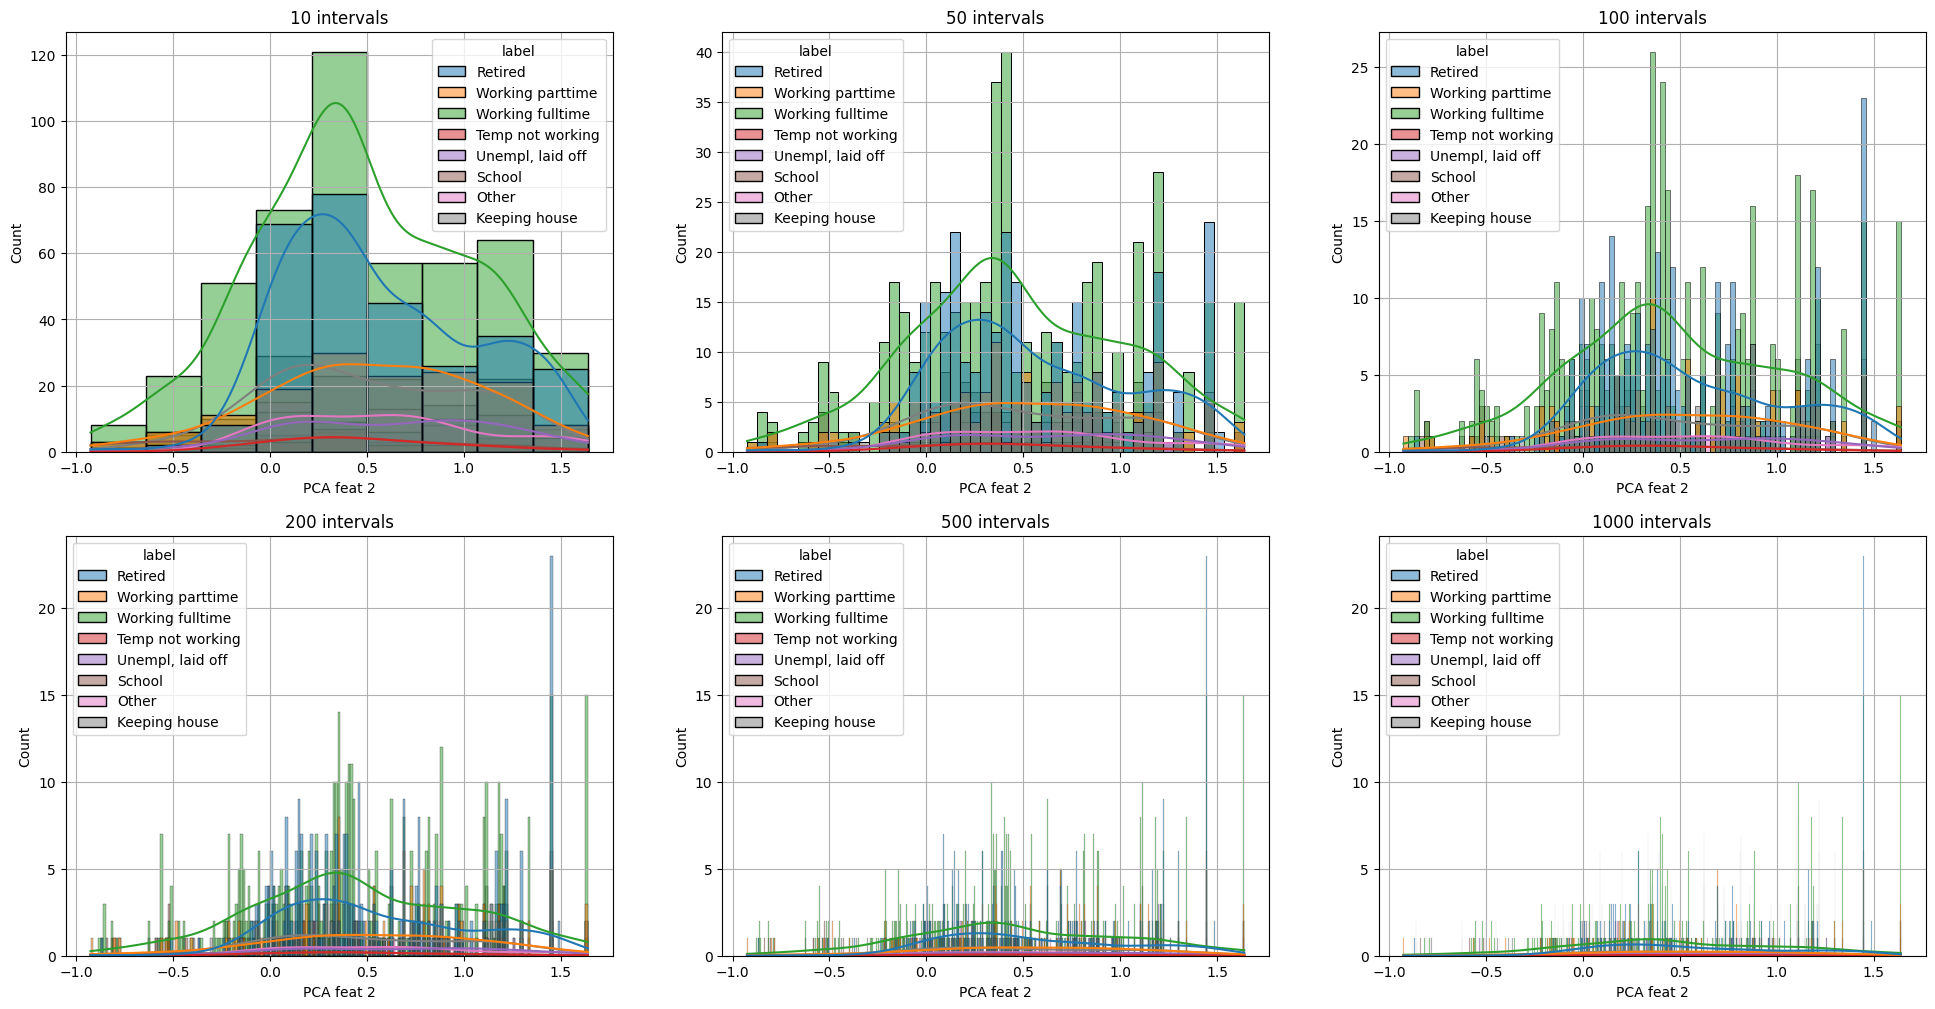

In [39]:
num_points = [10, 50, 100, 200, 500, 1000]

num_rows = (len(num_points) + 2) // 3
num_cols = min(len(num_points), 3)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 6 * num_rows))

axes = axes.ravel()

dim = 2

dominant_dim = reduced_x[:, dim]
temp_df = pd.DataFrame({"PCA feat {}".format(dim): dominant_dim, "label": y})

for i, n_point in enumerate(num_points):
    bins = np.linspace(np.min(dominant_dim), np.max(dominant_dim), n_point)
    sns.histplot(data=temp_df, x="PCA feat {}".format(dim), hue='label', bins=bins, kde=True, ax=axes[i])
    axes[i].set_title('{} intervals'.format(n_point))
    axes[i].grid()
    
for j in range(len(num_points), num_rows * num_cols):
    fig.delaxes(axes[j])

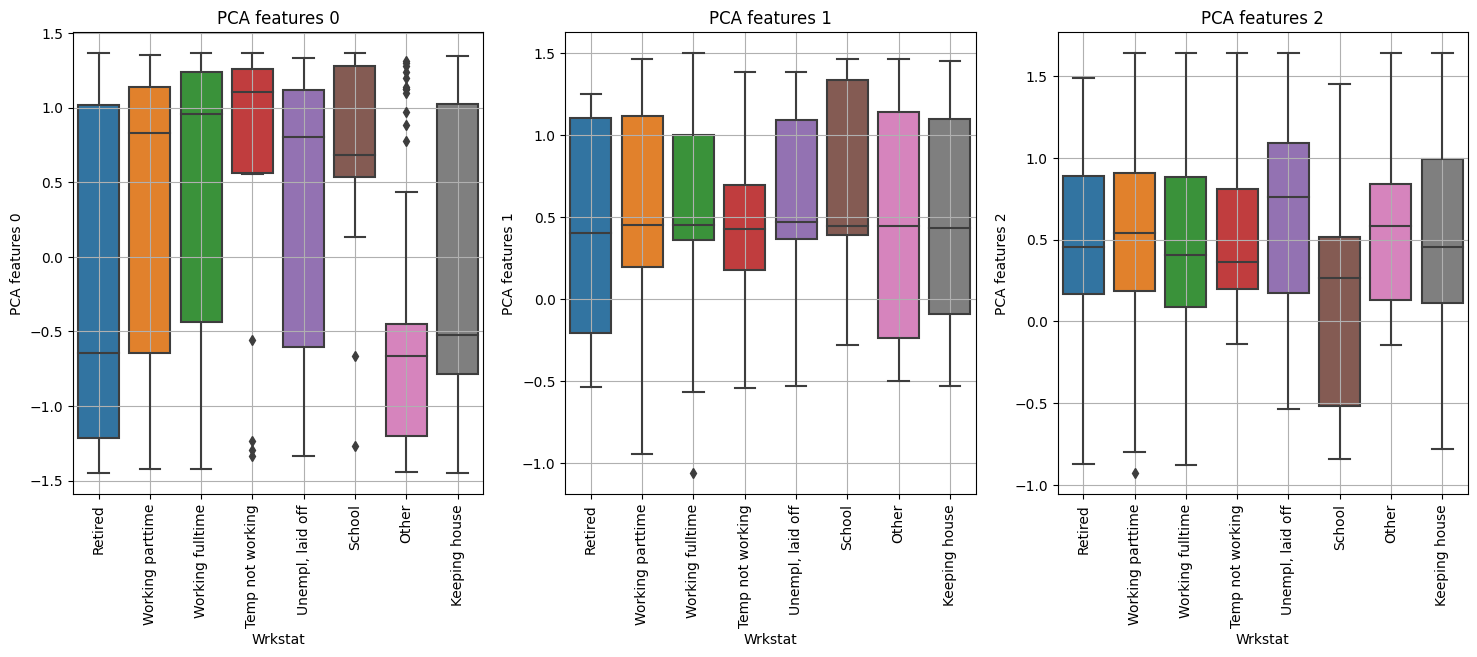

In [40]:
cols = 3
dims = [0, 1, 2]
rows = math.ceil(len(dims)/cols)
fig = plt.figure(figsize=(18, 6))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)
for i, dim in enumerate(dims):
    dominant_dim = reduced_x[:, dim]
    temp_df = pd.DataFrame({"PCA feat {}".format(dim): dominant_dim, "label": y})
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title("PCA features {}".format(dim))
    sns.boxplot( x='label', y="PCA feat {}".format(dim), data=temp_df)
    ax.set_ylabel("PCA features {}".format(dim))
    ax.set_xlabel('Wrkstat')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.grid()

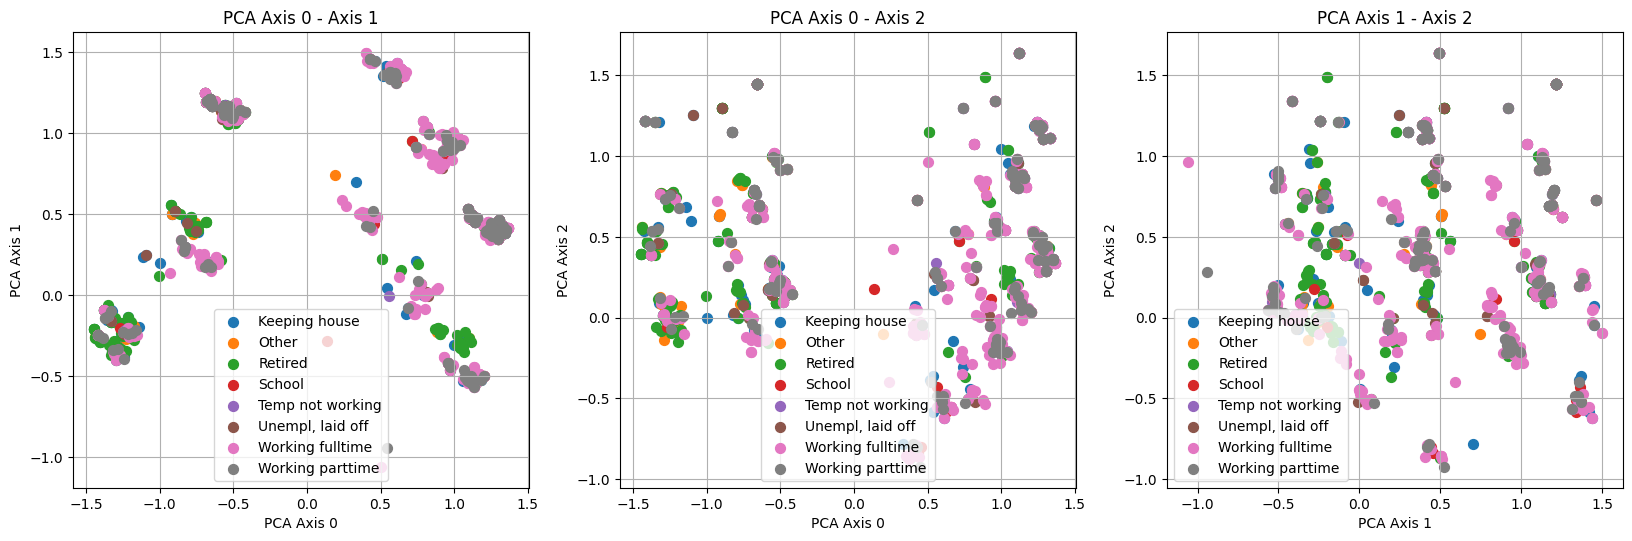

In [41]:
fig = plt.figure(figsize=(20, 20), facecolor='w')
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.1)
nums = len(list(combinations(range(reduced_x.shape[1]), r=2)))
cols = 3
rows = math.ceil(nums/cols)
i = 0

#fig, ax = plt.subplots(rows, cols)
for couple in combinations(range(reduced_x.shape[1]), r=2):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title("PCA Axis {} - Axis {}".format(couple[0], couple[1]))
    x_ax = reduced_x[:, couple[0]]
    y_ax = reduced_x[:, couple[1]]
    for g in np.unique(y):
        ix = np.where(y == g)
        ax.scatter(x_ax[ix], y_ax[ix], label=g, s=50)

    ax.set_xlabel("PCA Axis {}".format(couple[0]))
    ax.set_ylabel("PCA Axis {}".format(couple[1]))
    ax.set_aspect(abs((x_ax.max() - x_ax.min())/(y_ax.max() - y_ax.min()))*1.0)
    ax.grid()
    ax.legend()
    i += 1

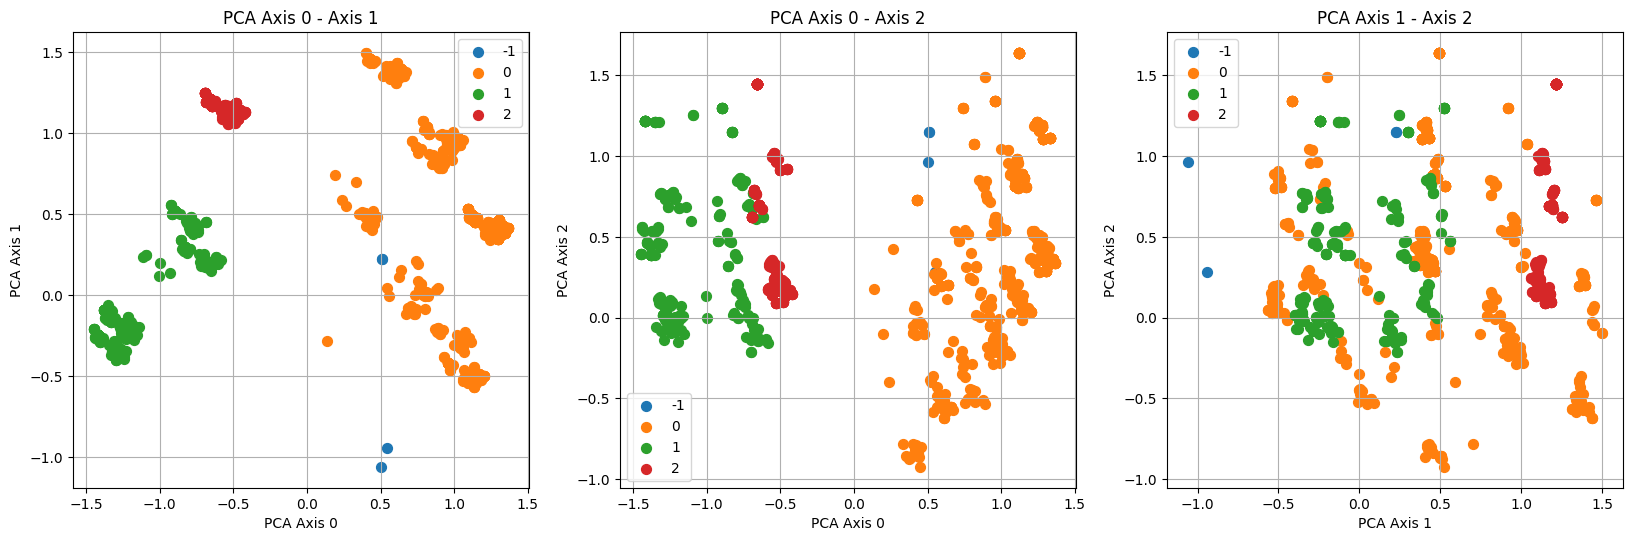

In [42]:
# clustering = DBSCAN(eps=0.55, min_samples=4).fit(reduced_x)
clustering = DBSCAN(eps=0.6, min_samples=4).fit(reduced_x)
#clustering = AgglomerativeClustering(n_clusters=3, linkage="complete").fit(reduced_x)
clus_label = clustering.labels_

fig = plt.figure(figsize=(20, 20), facecolor='w')
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2)
nums = len(list(combinations(range(reduced_x.shape[1]), r=2)))
cols = 3
rows = math.ceil(nums/cols)
i = 0

#fig, ax = plt.subplots(rows, cols)
for couple in combinations(range(reduced_x.shape[1]), r=2):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title("PCA Axis {} - Axis {}".format(couple[0], couple[1]))
    x_ax = reduced_x[:, couple[0]]
    y_ax = reduced_x[:, couple[1]]
    for g in np.unique(clus_label):
        ix = np.where(clus_label == g)
        ax.scatter(x_ax[ix], y_ax[ix], label=g, s=50)

    ax.set_xlabel("PCA Axis {}".format(couple[0]))
    ax.set_ylabel("PCA Axis {}".format(couple[1]))
    ax.set_aspect(abs((x_ax.max() - x_ax.min())/(y_ax.max() - y_ax.min()))*1.0)
    ax.grid()
    ax.legend()
    i += 1

In [43]:
X_train, X_test, y_train, y_test = train_test_split(np.real(reduced_x), clus_label, test_size=0.4, random_state=42)

In [44]:
model = LogisticRegression(multi_class='multinomial', solver='saga')
model.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', solver='saga')

In [45]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         3
           0       1.00      1.00      1.00       280
           1       0.97      1.00      0.99       102
           2       1.00      1.00      1.00        99

    accuracy                           0.99       484
   macro avg       0.74      0.75      0.75       484
weighted avg       0.99      0.99      0.99       484



c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [46]:
features_list = df_encoded.columns.tolist()
features_list.remove('wrkstat')
len(features_list), features_list

(45,
 ['harass5_0',
  'harass5_1',
  'harass5_2',
  'harass5_3',
  'snapchat_0',
  'snapchat_1',
  'snapchat_2',
  'instagrm_0',
  'instagrm_1',
  'instagrm_2',
  'polviews_0',
  'polviews_1',
  'polviews_2',
  'polviews_3',
  'polviews_4',
  'polviews_5',
  'polviews_6',
  'polviews_7',
  'advfront_0',
  'advfront_1',
  'advfront_2',
  'advfront_3',
  'advfront_4',
  'advfront_5',
  'educ_0',
  'educ_1',
  'educ_2',
  'educ_3',
  'educ_4',
  'educ_5',
  'educ_6',
  'educ_7',
  'educ_8',
  'educ_9',
  'educ_10',
  'educ_11',
  'educ_12',
  'educ_13',
  'educ_14',
  'educ_15',
  'educ_16',
  'educ_17',
  'educ_18',
  'educ_19',
  'educ_20'])

In [47]:
index_to_features_list = dict(zip(range(len(features_list)), features_list))

index_to_features_list

{0: 'harass5_0',
 1: 'harass5_1',
 2: 'harass5_2',
 3: 'harass5_3',
 4: 'snapchat_0',
 5: 'snapchat_1',
 6: 'snapchat_2',
 7: 'instagrm_0',
 8: 'instagrm_1',
 9: 'instagrm_2',
 10: 'polviews_0',
 11: 'polviews_1',
 12: 'polviews_2',
 13: 'polviews_3',
 14: 'polviews_4',
 15: 'polviews_5',
 16: 'polviews_6',
 17: 'polviews_7',
 18: 'advfront_0',
 19: 'advfront_1',
 20: 'advfront_2',
 21: 'advfront_3',
 22: 'advfront_4',
 23: 'advfront_5',
 24: 'educ_0',
 25: 'educ_1',
 26: 'educ_2',
 27: 'educ_3',
 28: 'educ_4',
 29: 'educ_5',
 30: 'educ_6',
 31: 'educ_7',
 32: 'educ_8',
 33: 'educ_9',
 34: 'educ_10',
 35: 'educ_11',
 36: 'educ_12',
 37: 'educ_13',
 38: 'educ_14',
 39: 'educ_15',
 40: 'educ_16',
 41: 'educ_17',
 42: 'educ_18',
 43: 'educ_19',
 44: 'educ_20'}

In [48]:
index_to_features_list_update = {}
for k, v in index_to_features_list.items():
    if v == "emailtotal":
        index_to_features_list_update[k] = v
    else:
        field, index = v.split("_")
        val_to_ind = {v: k for k, v in value_to_index[field].items()}
        #print(val_to_ind)
        if int(index) in val_to_ind:
            text_value = val_to_ind[int(index)]
            if isinstance(text_value, str):
                space_split = text_value.split(" ")
                if len(space_split) == 1:
                    index_to_features_list_update[k] = "{}_{}".format(field, space_split[0])
                else:
                    index_to_features_list_update[k] = "{}_{}".format(field, "_".join(space_split))
            else:
                index_to_features_list_update[k] = "{}_{}".format(field, int(text_value))
        else:
            index_to_features_list_update[k] = "{}_{}".format(field, "Unknown")
index_to_features_list = index_to_features_list_update
index_to_features_list

{0: 'harass5_Unknown',
 1: 'harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)',
 2: 'harass5_No',
 3: 'harass5_Yes',
 4: 'snapchat_Unknown',
 5: 'snapchat_No',
 6: 'snapchat_Yes',
 7: 'instagrm_Unknown',
 8: 'instagrm_No',
 9: 'instagrm_Yes',
 10: 'polviews_Unknown',
 11: 'polviews_Extrmly_conservative',
 12: 'polviews_Conservative',
 13: 'polviews_Slghtly_conservative',
 14: 'polviews_Moderate',
 15: 'polviews_Slightly_liberal',
 16: 'polviews_Liberal',
 17: 'polviews_Extremely_liberal',
 18: 'advfront_Unknown',
 19: 'advfront_Strongly_disagree',
 20: 'advfront_Disagree',
 21: 'advfront_Dont_know',
 22: 'advfront_Agree',
 23: 'advfront_Strongly_agree',
 24: 'educ_0',
 25: 'educ_1',
 26: 'educ_2',
 27: 'educ_3',
 28: 'educ_4',
 29: 'educ_5',
 30: 'educ_6',
 31: 'educ_7',
 32: 'educ_8',
 33: 'educ_9',
 34: 'educ_10',
 35: 'educ_11',
 36: 'educ_12',
 37: 'educ_13',
 38: 'educ_14',
 39: 'educ_15',
 40: 'educ_16',
 41: 'educ_17',
 42: 'educ_18',
 43: 'educ_19',
 44: 'educ_20'

In [49]:
pseudo_label = np.unique(clus_label)
index_to_pseudo_label = dict(zip(range(len(pseudo_label)), pseudo_label))
index_to_pseudo_label

{0: -1, 1: 0, 2: 1, 3: 2}

In [50]:
original_weights = model.coef_.dot(U.T)
# original_weights = model.coef_.dot(pca.components_)

In [51]:
importance = {}
for i in range(original_weights.shape[0]):
    importance[index_to_pseudo_label[i]] = dict(zip(np.vectorize(lambda x: index_to_features_list[x])(np.argsort(np.abs(original_weights[i]))[::-1]), np.round(original_weights[i][np.argsort(np.abs(original_weights[i]))[::-1]], 3)))
    
importance

{-1: {'instagrm_No': 0.481,
  'snapchat_No': 0.42,
  'polviews_Moderate': 0.305,
  'snapchat_Unknown': -0.264,
  'instagrm_Unknown': -0.264,
  'instagrm_Yes': -0.217,
  'snapchat_Yes': -0.156,
  'polviews_Conservative': -0.127,
  'educ_12': 0.102,
  'harass5_No': -0.097,
  'harass5_Yes': 0.077,
  'polviews_Liberal': -0.045,
  'polviews_Slightly_liberal': -0.038,
  'polviews_Slghtly_conservative': -0.033,
  'polviews_Extrmly_conservative': -0.026,
  'educ_14': -0.019,
  'educ_15': -0.019,
  'polviews_Unknown': -0.019,
  'educ_13': -0.018,
  'polviews_Extremely_liberal': -0.017,
  'educ_8': -0.016,
  'advfront_Agree': 0.015,
  'educ_11': -0.015,
  'harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)': 0.014,
  'educ_20': 0.014,
  'educ_6': -0.009,
  'educ_19': 0.008,
  'educ_7': -0.007,
  'advfront_Unknown': -0.006,
  'harass5_Unknown': 0.005,
  'educ_18': 0.005,
  'educ_16': -0.005,
  'educ_10': -0.004,
  'advfront_Disagree': -0.004,
  'educ_17': -0.003,
  'educ_5': -0.003,


In [52]:
X_train, X_test, y_train, y_test = train_test_split(x, clus_label, test_size=0.4, random_state=42)

In [53]:
model = LogisticRegression(multi_class='multinomial', solver='saga')
model.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', solver='saga')

In [54]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         3
           0       0.99      1.00      0.99       280
           1       1.00      1.00      1.00       102
           2       1.00      1.00      1.00        99

    accuracy                           0.99       484
   macro avg       0.75      0.75      0.75       484
weighted avg       0.99      0.99      0.99       484



c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [55]:
original_weights = model.coef_

In [56]:
importance = {}
for i in range(original_weights.shape[0]):
    importance[index_to_pseudo_label[i]] = dict(zip(np.vectorize(lambda x: index_to_features_list[x])(np.argsort(np.abs(original_weights[i]))[::-1]), np.round(original_weights[i][np.argsort(np.abs(original_weights[i]))[::-1]], 3)))
    
importance

{-1: {'harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)': 0.687,
  'snapchat_Yes': 0.649,
  'instagrm_No': 0.539,
  'harass5_No': -0.455,
  'educ_12': 0.432,
  'polviews_Moderate': 0.42,
  'snapchat_Unknown': -0.411,
  'instagrm_Unknown': -0.411,
  'snapchat_No': -0.244,
  'harass5_Yes': -0.173,
  'instagrm_Yes': -0.134,
  'polviews_Conservative': -0.094,
  'polviews_Slghtly_conservative': -0.081,
  'educ_16': -0.072,
  'educ_14': -0.071,
  'harass5_Unknown': -0.065,
  'educ_13': -0.062,
  'polviews_Liberal': -0.059,
  'polviews_Slightly_liberal': -0.055,
  'polviews_Extremely_liberal': -0.054,
  'advfront_Unknown': 0.053,
  'polviews_Unknown': -0.045,
  'polviews_Extrmly_conservative': -0.039,
  'educ_20': -0.031,
  'advfront_Agree': -0.03,
  'educ_15': -0.029,
  'educ_11': -0.029,
  'educ_10': -0.027,
  'educ_9': -0.024,
  'educ_8': -0.022,
  'educ_18': -0.021,
  'educ_17': -0.02,
  'advfront_Strongly_agree': -0.013,
  'advfront_Disagree': -0.012,
  'educ_6': -0.009,
 